# Data loading, cleaning and exploration

We start with adding packages that we need for the task of data exploration. 

In [1]:
!pip install pandas
!pip install .\pycld2-0.41-cp39-cp39-win_amd64.whl
!pip install langdetect
!pip install matplotlib
!pip install pywsd
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install tmtoolkit
!pip install gensim
!pip install pyLDAvis
!pip install seq2pat
!pip install prefixspan

Processing c:\users\elina\documents\radboud\masters\research-internship\pycld2-0.41-cp39-cp39-win_amd64.whl
pycld2 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import os, sys
path = os.path.join(os.path.abspath(""), 'internship-env', 'Lib', 'site-packages')
sys.path.append(path)

import glob
import json
import string
import math
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.model_selection import train_test_split
import random

import langdetect
import pycld2 as cld2

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Set random seed to 42
random.seed(42)

import re
import shlex
import keyword

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Define stop words
stop_words = stopwords.words('english')
process_latest_conversations = True

In [4]:
devgpt_location = "./DevGPT/"
github_devgpt_snapshot_folders = [path for path,_,_ in os.walk(devgpt_location) if "snapshot" in path]
commits_json_filepaths = []
issues_json_filepaths = []
discussion_json_filepaths = []
pull_requests_json_filepaths = []
code_json_filepaths = []
hackernews_json_filepaths = []


for snapshot_folder in github_devgpt_snapshot_folders:
    json_file_paths = glob.glob(f'{snapshot_folder}/*.json')
    for json_file_path in json_file_paths:
        if "commit" in json_file_path:
            commits_json_filepaths.append(json_file_path)
        elif "issue" in json_file_path:
            issues_json_filepaths.append(json_file_path)
        elif "discussion" in json_file_path:
            discussion_json_filepaths.append(json_file_path)
        elif "pr" in json_file_path:
            pull_requests_json_filepaths.append(json_file_path)
        elif "file" in json_file_path:
            code_json_filepaths.append(json_file_path)
        elif "hn" in json_file_path:
            hackernews_json_filepaths.append(json_file_path)
        else:
            raise Exception(f"JSON file '{json_file_paths}' was not recognised!")

""" Uncomment to print out all the file paths!
print(commits_json_filepaths)
print(issues_json_filepaths)
print(discussion_json_filepaths)
print(pull_requests_json_filepaths)
print(code_json_filepaths)
print(hackernews_json_filepaths)
"""

' Uncomment to print out all the file paths!\nprint(commits_json_filepaths)\nprint(issues_json_filepaths)\nprint(discussion_json_filepaths)\nprint(pull_requests_json_filepaths)\nprint(code_json_filepaths)\nprint(hackernews_json_filepaths)\n'

In [5]:
if process_latest_conversations:
    latest_data_path = "./latest_gpt_conversations/"
    json_file_paths = glob.glob(f'{latest_data_path}/*.json')
    print(json_file_paths)
    for json_file_path in json_file_paths:
        if "commit" in json_file_path:
            commits_json_filepaths.append(json_file_path)
        elif "issue" in json_file_path:
            issues_json_filepaths.append(json_file_path)
        elif "discussion" in json_file_path:
            discussion_json_filepaths.append(json_file_path)
        elif "pr" in json_file_path:
            pull_requests_json_filepaths.append(json_file_path)
        elif "repo" in json_file_path:
            code_json_filepaths.append(json_file_path)
        elif "hn" in json_file_path:
            hackernews_json_filepaths.append(json_file_path)
        else:
            raise Exception(f"JSON file '{json_file_path}' was not recognised!")

['./latest_gpt_conversations\\20250327_095248_discussion_sharings.json', './latest_gpt_conversations\\20250327_095517_repo_sharings.json', './latest_gpt_conversations\\20250327_095547_pr_sharings.json', './latest_gpt_conversations\\20250327_100729_hn_sharings.json', './latest_gpt_conversations\\20250327_123620_commit_sharings.json', './latest_gpt_conversations\\20250327_124328_issue_sharings.json']


We start with looking closely at what data is contained in the files and whether newer snapshots were just appended with new information, but contain old snapshot information as well, or they just contain information that was created after the last snapshot was combined. 

In [6]:
# ========================= Columns =========================
commit_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message']
code_file_columns = ['Type', 'URL', 'RepoName', 'RepoLanguage']
issue_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'State']
pull_request_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'CommitSha']
hacker_news_columns = ['Type', 'ID', 'URL', 'AttachedURL', 'Title', 'CreatedAt']
discussion_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'Closed', 'UpvoteCount']
mention_columns = ['MentionedURL', 'MentionedProperty', 'MentionedAuthor', 'MentionedText', 'MentionedPath','MentionedAnswer', 'MentionedUpvoteCount']
gpt_sharing_columns = ['SharingURL', 'Status', 'DateOfConversation', 'DateOfAccess', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations']

# ========================= Processing functions =========================
def process_commit_json(commit):
    commit_array_of_elements = [commit[col] for col in commit_columns]
    return commit_array_of_elements

def process_code_files_json(code_file):
    code_files_array_of_elements = [code_file[col] for col in code_file_columns]
    return code_files_array_of_elements

def process_issue_json(issue):
    issue_array_of_elements = [issue[col] if (col in issue) else "" for col in issue_columns]
    return issue_array_of_elements

def process_pull_request_json(pull_request):
    pull_request_array_of_elements = [pull_request[col] if (col in pull_request) else "" for col in pull_request_columns]
    return pull_request_array_of_elements

def process_hacker_news_json(hacker_news):
    hacker_news_array_of_elements = [hacker_news[col] for col in hacker_news_columns]
    return hacker_news_array_of_elements

def process_discussion_json(discussion):
    discussion_array_of_elements = [discussion[col] if (col in discussion) else "" for col in discussion_columns]
    return discussion_array_of_elements

def process_sharing_json(sharing):
    gptsharing_array_of_elements = [sharing['URL']]
    gptsharing_array_of_elements += [sharing[col] for col in gpt_sharing_columns[1:]]
    mention = sharing['Mention']
    gptsharing_array_of_elements += [mention[col] if (col in mention) else "" for col in mention_columns]
    return gptsharing_array_of_elements

In [7]:
def read_json_data_from_files_to_dataframe(filepaths_list):
    file_sharings_df = pd.DataFrame()
    for json_filepath in filepaths_list:
        with open(json_filepath, 'r') as file:
            # Load JSON data from file
            json_data = json.load(file)
            data_to_df = []
            sources = json_data['Sources'] if 'DevGPT' in json_filepath else json_data
            for source in sources:
                source_array = []
                columns_for_df = []
                if source['Type'] == 'commit':
                    source_array = process_commit_json(source)
                    columns_for_df = commit_columns
                elif source['Type'] == 'code file' or source['Type'] == 'repository':
                    source_array = process_code_files_json(source)
                    columns_for_df = code_file_columns
                elif source['Type'] == 'issue':
                    source_array = process_issue_json(source)
                    columns_for_df = issue_columns
                elif source['Type'] == 'pull request':
                    source_array = process_pull_request_json(source)
                    columns_for_df = pull_request_columns
                elif source['Type'] == 'hacker news':
                    source_array = process_hacker_news_json(source)
                    columns_for_df = hacker_news_columns
                elif source['Type'] == 'discussion':
                    source_array = process_discussion_json(source)
                    columns_for_df = discussion_columns
                else:
                    print(f"Unexpected type of the course: '{source['Type']}'")
                    raise
                for sharing in source['ChatgptSharing']:
                    if sharing['Status'] != 200:
                        continue
                    sharing_array = process_sharing_json(sharing)
                    data_to_df.append(source_array + sharing_array)
            file_dataframe = pd.DataFrame(data_to_df, columns=columns_for_df + gpt_sharing_columns + mention_columns)
            print(f"Data from '{json_filepath}' file contains {len(file_dataframe)} elements.")
            file_sharings_df = pd.concat([file_sharings_df, file_dataframe])
    print(f"When all the dataframes were concatenated/appended, we have total of {len(file_sharings_df)} rows in the DF.")
    file_sharings_df = file_sharings_df.drop_duplicates(subset=['SharingURL'], keep='last') # Keep newest
    print(f"After removing the duplicated based on ChatGPT URL of the source, we have total of {len(file_sharings_df)} rows in the DF.")
    return file_sharings_df

In [8]:
commits_dataframe = read_json_data_from_files_to_dataframe(commits_json_filepaths)
commits_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200003_commit_sharings.json' file contains 178 elements.
Data from './DevGPT/snapshot_20230803\20230803_095317_commit_sharings.json' file contains 214 elements.
Data from './DevGPT/snapshot_20230810\20230810_124807_commit_sharings.json' file contains 301 elements.
Data from './DevGPT/snapshot_20230817\20230817_131244_commit_sharings.json' file contains 198 elements.
Data from './DevGPT/snapshot_20230824\20230824_102435_commit_sharings.json' file contains 199 elements.
Data from './DevGPT/snapshot_20230831\20230831_063412_commit_sharings.json' file contains 477 elements.
Data from './DevGPT/snapshot_20230907\20230907_110036_commit_sharings.json' file contains 398 elements.
Data from './DevGPT/snapshot_20230914\20230914_083202_commit_sharings.json' file contains 568 elements.
Data from './DevGPT/snapshot_20230914\.ipynb_checkpoints\20230914_083202_commit_sharings-checkpoint.json' file contains 568 elements.
Data from './DevGPT/snapshot_20231

,Type,URL,Author,RepoName,RepoLanguage,Sha,Message,SharingURL,Status,DateOfConversation,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
7,commit,https://github.com/Hamza-Eng/baldie/commit/3a7...,Hamza-Eng,Hamza-Eng/baldie,Blade,3a7364f2ab5e67c80aa4f61f644f315e4b233390,add facebook pixel\n\nfor more information you...,https://chat.openai.com/share/e6c824b7-bf94-4b...,200,"July 21, 2023",...,2097,,"[{'Prompt': 'add facebook pixel to laravel ', ...",https://github.com/Hamza-Eng/baldie/commit/3a7...,message,Hamza-Eng,add facebook pixel\n\nfor more information you...,,,
19,commit,https://github.com/jdustinwilliams/hibddbs/com...,dzdn,jdustinwilliams/hibddbs,CSS,e6a01ec078e950a277e7caa21affd7c4ae23d244,Make advanced search concise\n\nUsed ChatGPT f...,https://chat.openai.com/share/e476a2d0-5c29-4c...,200,"August 22, 2023",...,1067,Default,[{'Prompt': 'Is there a way I could make this ...,https://github.com/jdustinwilliams/hibddbs/com...,message,dzdn,Make advanced search concise\n\nUsed ChatGPT f...,,,
0,commit,https://github.com/grnpin/textbox/commit/fa335...,grnpin,grnpin/textbox,HTML,fa335cf2ec447d00f8e94b54a8b463725b92947c,https://chat.openai.com/share/4bad57dd-9636-4b...,https://chat.openai.com/share/4bad57dd-9636-4b...,200,"September 20, 2023",...,556,Default (GPT-3.5),[{'Prompt': 'このコードだと、スマートフォンでキーボードを表示したときにbutt...,https://github.com/grnpin/textbox/commit/fa335...,message,grnpin,https://chat.openai.com/share/4bad57dd-9636-4b...,,,
1,commit,https://github.com/grnpin/textbox/commit/0dfc4...,grnpin,grnpin/textbox,HTML,0dfc4385b723060e1e6a21da17a952bd908084ff,https://chat.openai.com/share/1fd7ffc2-9264-45...,https://chat.openai.com/share/1fd7ffc2-9264-45...,200,"September 9, 2023",...,160,Default,[{'Prompt': 'このコードなんですが、Placeholder上でちゃんと改行するコ...,https://github.com/grnpin/textbox/commit/0dfc4...,message,grnpin,https://chat.openai.com/share/1fd7ffc2-9264-45...,,,
2,commit,https://github.com/grnpin/textbox/commit/811d0...,grnpin,grnpin/textbox,HTML,811d09acdca361c81281c7d71587ebdbd8437453,https://chat.openai.com/share/99d2d02f-7e3b-43...,https://chat.openai.com/share/99d2d02f-7e3b-43...,200,"September 7, 2023",...,115,Default,[{'Prompt': 'refactor this code. <!DOCTYPE ht...,https://github.com/grnpin/textbox/commit/811d0...,message,grnpin,https://chat.openai.com/share/99d2d02f-7e3b-43...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,commit,https://github.com/bpbpublications/Modern-Pyth...,gshiva,bpbpublications/Modern-Python-Programming-usin...,Python,3adeb8a3e25142cf93ff5fe584b83d86ebab22e3,"Completes Unit,Integration, System and Accept...",https://chat.openai.com/share/ed5cf830-e99a-47...,200,"December 26, 2023",...,8467,GPT-3.5,[{'Prompt': 'How to get rid of this warning? ...,https://github.com/bpbpublications/Modern-Pyth...,message,gshiva,"Completes Unit,Integration, System and Accept...",,,
1364,commit,https://github.com/bpbpublications/Modern-Pyth...,gshiva,bpbpublications/Modern-Python-Programming-usin...,Python,3adeb8a3e25142cf93ff5fe584b83d86ebab22e3,"Completes Unit,Integration, System and Accept...",https://chat.openai.com/share/2ab02c29-ed15-45...,200,"December 26, 2023",...,11896,GPT-3.5,[{'Prompt': 'All these code have no tests. I w...,https://github.com/bpbpublications/Modern-Pyth...,message,gshiva,"Completes Unit,Integration, System and Accept...",,,
1365,commit,https://github.com/fel-dev/Aprenda-BDD-com-Cuc...,Felipe Carneiro,fel-dev/Aprenda-BDD-com-Cucumber-em-JAVA,Java,1e040e6b9932930ffdb27966177c53aa803959f5,Exprecoes Regulares\n\n12. Reaproveitando cená...,https://chat.openai.com/share/1bb2f0db-2ef8-49...,200,"December 27, 2023",...,1024,GPT-3.5,"[{'Prompt': 'expressÃ£o regular para data', 'A...",https://github.com/fel-dev/Aprenda-BDD-com-Cuc...,message,Felipe Carneiro,Exprecoes Regulares\n\n12. Reaproveitando cená...,,,
1366,commit,https://github.com/Arushan2/C

In [9]:
issues_dataframe = read_json_data_from_files_to_dataframe(issues_json_filepaths)
issues_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195941_issue_sharings.json' file contains 243 elements.
Data from './DevGPT/snapshot_20230803\20230803_094705_issue_sharings.json' file contains 264 elements.
Data from './DevGPT/snapshot_20230810\20230810_123938_issue_sharings.json' file contains 306 elements.
Data from './DevGPT/snapshot_20230817\20230817_130502_issue_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20230824\20230824_101836_issue_sharings.json' file contains 369 elements.
Data from './DevGPT/snapshot_20230831\20230831_061759_issue_sharings.json' file contains 384 elements.
Data from './DevGPT/snapshot_20230907\20230907_092956_issue_sharings.json' file contains 419 elements.
Data from './DevGPT/snapshot_20230914\20230914_080417_issue_sharings.json' file contains 503 elements.
Data from './DevGPT/snapshot_20231012\20231012_235128_issue_sharings.json' file contains 598 elements.
Data from './latest_gpt_conversations\20250327_124328_issue_sharings.json

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
11,issue,https://github.com/relaycorp/terraform-google-...,gnarea,relaycorp/terraform-google-awala-endpoint,HCL,4,Run bootstrapping job automatically every time...,See:\r\n\r\n- https://chat.openai.com/share/71...,,None,...,694,Default,[{'Prompt': 'I'm using Terraform to manage som...,https://github.com/relaycorp/terraform-google-...,body,gnarea,See:\r\n\r\n- https://chat.openai.com/share/71...,,,
157,issue,https://github.com/ookunirina/my_cinema_record...,ookunirina,ookunirina/my_cinema_record,Ruby,60,TMDb APIを使い投稿作成時のタイトル部分をオートコンプリートにする方法,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,None,...,1161,Default,[{'Prompt': '貴方は、Ruby on Railsでアプリ制作をする初心者エンジニ...,https://github.com/ookunirina/my_cinema_record...,body,ookunirina,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,,
119,issue,https://github.com/mostypc123/XediX/issues/6,mostypc123,mostypc123/XediX,Python,6,Firebase,How to connect Python to Firebase?,,2023-08-14T14:47:48Z,...,228,Default,[{'Prompt': 'Can I connect Firebase to my Pyth...,https://github.com/mostypc123/XediX/issues/6#i...,comments.body,mostypc123,"Completed, AI says me how to connect it. Chat:...",,,
29,issue,https://github.com/yeu-github/model/issues/1,yeu-github,yeu-github/model,None,1,melih,--,,None,...,3833,Default,[{'Prompt': 'euler acısını gorsellestiren bir ...,https://github.com/yeu-github/model/issues/1#i...,comments.body,yeu-github,https://chat.openai.com/share/0b1cd1fb-57e0-41...,,,
101,issue,https://github.com/micartey/jation/issues/2,micartey,micartey/jation,Java,2,ASM,Create a runtime dummy class that implements a...,,None,...,15961,Default,[{'Prompt': 'How can I use asm to generate exe...,https://github.com/micartey/jation/issues/2#is...,comments.body,micartey,https://chat.openai.com/share/2a8f82bb-ce20-49...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,issue,https://github.com/agile-learning-institute/me...,FlatBallFlyer,agile-learning-institute/mentorHub-mongodb,Dockerfile,35,Finalize Topic Collection Schema,Review use cases for the Topic data structure ...,,2024-02-25T21:00:13Z,...,638,GPT-3.5,"[{'Prompt': 'Evalutate these claims: ""@michqui...",https://github.com/agile-learning-institute/me...,comments.body,GrahamPaasch,"@michquinn Regarding learningStyles, @FlatBall...",,,
1228,issue,https://github.com/agile-learning-institute/me...,FlatBallFlyer,agile-learning-institute/mentorHub-mongodb,Dockerfile,35,Finalize Topic Collection Schema,Review use cases for the Topic data structure ...,,2024-02-25T21:00:13Z,...,3535,GPT-3.5,[{'Prompt': 'Skip to content agile-learning-in...,https://github.com/agile-learning-institute/me...,comments.body,GrahamPaasch,"@michquinn Regarding learningStyles, @FlatBall...",,,
1231,issue,https://github.com/agile-learning-institute/me...,FlatBallFlyer,agile-learning-institute/mentorHub-mongodb,Dockerfile,35,Finalize Topic Collection Schema,Review use cases for the Topic data structure ...,,2024-02-25T21:00:13Z,...,3678,GPT-3.5,[{'Prompt': 'Act as the best possible expert t...,https://github.com/agile-learning-institute/me...,comments.body,GrahamPaasch,Here's a PR I made. While it does make sense t...,,,
1232,issue,https://github.com/raspiblitz/raspiblitz/issue...,kravens,raspiblitz/raspiblitz,Python,4496,1.11.0RC5 BTCpayserver won't start after updat...,**Describe the bug**\r\nSomething is going wro...,,2024-04-10T10:12:23Z,...,726,GPT-3.5,[{'Prompt': 'One additional issue can be that ...,https://github.com/raspiblitz/raspiblitz/issue...,comments.body,openoms,There are some extra steps here we did not con...,,,


In [10]:
discussions_dataframe = read_json_data_from_files_to_dataframe(discussion_json_filepaths)
discussions_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195954_discussion_sharings.json' file contains 33 elements.
Data from './DevGPT/snapshot_20230803\20230803_094811_discussion_sharings.json' file contains 35 elements.
Data from './DevGPT/snapshot_20230810\20230810_124048_discussion_sharings.json' file contains 38 elements.
Data from './DevGPT/snapshot_20230817\20230817_130721_discussion_sharings.json' file contains 43 elements.
Data from './DevGPT/snapshot_20230824\20230824_102000_discussion_sharings.json' file contains 45 elements.
Data from './DevGPT/snapshot_20230831\20230831_061926_discussion_sharings.json' file contains 46 elements.
Data from './DevGPT/snapshot_20230907\20230907_093129_discussion_sharings.json' file contains 50 elements.
Data from './DevGPT/snapshot_20230914\20230914_080601_discussion_sharings.json' file contains 55 elements.
Data from './DevGPT/snapshot_20231012\20231012_235320_discussion_sharings.json' file contains 61 elements.
Data from './latest_gpt_conversations

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,discussion,https://github.com/xihajun/Projects/discussions/3,xihajun,xihajun/Projects,Jupyter Notebook,3,ONNX model,学习ONNX： https://chat.openai.com/share/f868e43e...,,None,...,2204,Advanced Data Analysis,[{'Prompt': '什么是ONNX模型？我是一名新生，您是世界上最好的老师，也是最优秀...,https://github.com/xihajun/Projects/discussions/3,body,xihajun,学习ONNX： https://chat.openai.com/share/f868e43e...,,,
1,discussion,https://github.com/vueuse/vueuse/discussions/3355,bobmulder,vueuse/vueuse,TypeScript,3355,An utility method to trigger a function when s...,"Hi all,\r\n\r\nI have a usecase where I want t...",,None,...,428,Default (GPT-3.5),[{'Prompt': 'I have a vue 3 application. I hav...,https://github.com/vueuse/vueuse/discussions/3355,body,bobmulder,"Hi all,\r\n\r\nI have a usecase where I want t...",,,
2,discussion,https://github.com/huangyinhaow/blogGiscus/dis...,giscus,huangyinhaow/blogGiscus,None,11,屠呦呦：跨界者还是守界者？,# 屠呦呦：跨界者还是守界者？\n\n探讨屠呦呦：她是跨界者还是守界者？\n\nhttps:...,,None,...,1158,Default (GPT-3.5),[{'Prompt': '使以下文章更有逻辑性 屠呦呦究竟是跨界者还是守界者 时光如白驹...,https://github.com/huangyinhaow/blogGiscus/dis...,comments.body,huangyinhaow,https://chat.openai.com/share/9495ba64-83ce-41...,,,1
3,discussion,https://github.com/git-lfs/git-lfs/discussions...,ggrrll,git-lfs/git-lfs,Go,5457,documentation on reverting / untracking,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,None,...,533,Default (GPT-3.5),[{'Prompt': ' migrate back to git files tracke...,https://github.com/git-lfs/git-lfs/discussions...,body,ggrrll,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,,
4,discussion,https://github.com/prgrms-fe-devcourse/FEDC4_H...,jkea1,prgrms-fe-devcourse/FEDC4_HONKOK_JunilHwang,TypeScript,47,랜덤한 id 생성하기,id 생성을 라이브러리 사용을 안하고 커스텀 함수로 만든다고 들었던거 같은데 내일 ...,,None,...,281,Default (GPT-3.5),[{'Prompt': '자바스크립트로 랜덤한 id를 생성하는 함수 코드를 알려줘.'...,https://github.com/prgrms-fe-devcourse/FEDC4_H...,comments.body,jgjgill,gpt에 물어봤습니다..!\r\nhttps://chat.openai.com/shar...,,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,discussion,https://github.com/Laravel-Backpack/community-...,tabacitu,Laravel-Backpack/community-forum,None,728,[WIP] ChatGPT bot to answer people on Github,So I've been investigating this for a while no...,,None,...,1854,GPT-3.5,[{'Prompt': 'Is the WebPilot extension working...,https://github.com/Laravel-Backpack/community-...,comments.body,tabacitu,I also tried ChatGPT 4 with [WebPilot](https:/...,,,
66,discussion,https://github.com/openai/openai-node/discussi...,rattrayalex,openai/openai-node,TypeScript,217,v3 to v4 Migration Guide,v4 is a complete rewrite of the SDK. To see wh...,,None,...,7,GPT-3.5,[{'Prompt': 'Skip to content openai / openai-n...,https://github.com/openai/openai-node/discussi...,comments.body,foxalabs,https://chat.openai.com/share/b175130a-0d77-46...,,,
67,discussion,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,ZoeLeBlanc,ZoeLeBlanc/is578-intro-dh,HTML,1,AI & CLI Assignment,Post the results of your assignment here and s...,,None,...,2853,GPT-3.5,[{'Prompt': 'provide a how to for using the co...,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,comments.body,rubylm2,I compared ChatGPT and Google's Bard (full pro...,,,
68,discussion,https://github.com/pukpr/GeoEnergyMath/discuss...,pukpr,pukpr/GeoEnergyMath,Ada,26,NINO34+PDO+AMO,The idea here is to use NINO34 and PDO model f...,,None,...,2190,GPT-3.5,[{'Prompt': 'Identify the Saros and lunar noda...,https://github.com/pukpr/GeoEnergyMath/discuss...,comments.body,pukpr,### Darwin Saros\r\n\r\n![image](https://githu...,,,


In [11]:
pull_requests_dataframe = read_json_data_from_files_to_dataframe(pull_requests_json_filepaths)
pull_requests_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195927_pr_sharings.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230727\.ipynb_checkpoints\20230727_195927_pr_sharings-checkpoint.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230803\20230803_093947_pr_sharings.json' file contains 166 elements.
Data from './DevGPT/snapshot_20230810\20230810_123110_pr_sharings.json' file contains 175 elements.
Data from './DevGPT/snapshot_20230817\20230817_125147_pr_sharings.json' file contains 184 elements.
Data from './DevGPT/snapshot_20230824\20230824_100450_pr_sharings.json' file contains 197 elements.
Data from './DevGPT/snapshot_20230831\20230831_060603_pr_sharings.json' file contains 208 elements.
Data from './DevGPT/snapshot_20230907\20230907_091631_pr_sharings.json' file contains 220 elements.
Data from './DevGPT/snapshot_20230914\20230914_074826_pr_sharings.json' file contains 231 elements.
Data from './DevGPT/snapshot_20231012\20231012_233628_pr_sharings.json

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,CreatedAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
2,pull request,https://github.com/nestoca/actions/pull/29,felleg,nestoca/actions,Go,29,feat(devops-1790): create reusable action to p...,Questions left to answer:\r\n\r\n- To do my do...,2023-08-02T19:36:31Z,None,...,4455,,[{'Prompt': 'i want to create a github action ...,https://github.com/nestoca/actions/pull/29,body,felleg,Questions left to answer:\r\n\r\n- To do my do...,,,
91,pull request,https://github.com/nestoca/actions/pull/30,alexstojda,nestoca/actions,Go,30,feat(DEVOPS-1846): monorepo - Auto-promote PR ...,,2023-08-11T00:19:44Z,2023-08-15T21:04:38Z,...,416,Default,"[{'Prompt': 'In github actions, I have this co...",https://github.com/nestoca/actions/pull/30#dis...,reviews.body,silphid,Was wondering whether we could make this more ...,build-monorepo-app/action.yaml,,
67,pull request,https://github.com/n-koga96/practice-React-exa...,n-koga96,n-koga96/practice-React-example-1,JavaScript,1,練習ブランチ１,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,2023-06-09T05:02:58Z,2023-07-11T03:40:40Z,...,5415,Default,[{'Prompt': '自分のmac PCにnode.jsが入っているかどうかを確かめるコ...,https://github.com/n-koga96/practice-React-exa...,body,n-koga96,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,,,
106,pull request,https://github.com/zhyunk/zb-mission-store-res...,zhyunk,zhyunk/zb-mission-store-reserve,Java,54,"#29 service , controller 정리",this closes #29,2023-08-02T18:11:46Z,2023-08-02T18:11:54Z,...,553,Default,"[{'Prompt': 'java에서 단일 객체를 반환하는 최종 연산자', 'Answ...",https://github.com/zhyunk/zb-mission-store-res...,reviews.body,zhyunk,최종 연산자\r\nhttps://chat.openai.com/share/db0905...,mission/src/main/java/kim/zhyun/mission/seller...,,
131,pull request,https://github.com/ubiquity/ubiquity-dollar/pu...,ghost,ubiquity/ubiquity-dollar,None,724,add the cspell in husky,Resolves #562 \r\n,2023-07-08T19:11:22Z,2023-07-09T13:35:08Z,...,747,Default,[{'Prompt': 'I have an active codebase with a ...,https://github.com/ubiquity/ubiquity-dollar/pu...,comments.body,molecula451,> https://chat.openai.com/share/084a9c22-efea-...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,pull request,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,JavaScript,5,Addressing module not defined error in browser.,https://chat.openai.com/share/75cd8eae-6bf6-47...,2023-07-03T15:59:32Z,2023-07-03T16:20:19Z,...,6248,GPT-3.5,[{'Prompt': 'When I am playing the game in the...,https://github.com/hoshotakamoto/banzukesurfin...,body,hoshotakamoto,https://chat.openai.com/share/75cd8eae-6bf6-47...,,,
836,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,qryxip,VOICEVOX/voicevox_core,Rust,532,ドキュメントを刷新する,## 内容\r\n\r\nRust/C/Python APIのドキュメントを刷新します。\r...,2023-06-25T14:03:16Z,2023-08-02T11:22:43Z,...,2553,GPT-3.5,[{'Prompt': 'ãã¡ãã®å¤æ´ã«å¯¾ãã¦ã...,ドラマとかでよく「被害者を解放しろ！」とか聞くのと、字面が「解き放つ」なのでまあ１０割の人に...,reviews.comments.body,Hiroshiba,ドラマとかでよく「被害者を解放しろ！」とか聞くのと、字面が「解き放つ」なのでまあ１０割の人に...,,,
837,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,sevenc-nanashi,VOICEVOX/voicevox_core,Rust,538,[vvm-async-api] Add: ユーザー辞書APIを追加,## 内容\r\n\r\nユーザー辞書を実装します。\r\n\r\n## 関連 Issue\...,2023-07-08T15:05:40Z,2023-07-22T14:01:36Z,...,1351,GPT-3.5,[{'Prompt': 'ãã®2ã¤ã®å¦çã¯ä¸ç·ã§ã...,ChatGPT君に違いを聞いてみたら、最初に空白を全角空白にしていないとのことでした！\r\...,reviews.comments.body,Hiroshiba,ChatGPT君に違いを聞いてみたら、最初に空白を全角空白にしていないとのことでした！\r\...,,,
838,pull request,https://github.com/openai/evals/pull/1083,AaronGoldsmith,openai/evals,Python,1083,[Eval] Viewport to grid size,# Thank you for contributing an eval! ♥️\r\n\r...,2023-06-02T02:53:27Z,2023-07-04T02:05:57Z,...,3014,GPT-3.5,[{'Prompt': 'I'm having trouble understanding ...,https://github.com/openai/evals/pull/1083,body,AaronGoldsmith,# Than

In [12]:
code_dataframe = read_json_data_from_files_to_dataframe(code_json_filepaths)
code_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200102_file_sharings.json' file contains 957 elements.
Data from './DevGPT/snapshot_20230803\20230803_103605_file_sharings.json' file contains 1052 elements.
Data from './DevGPT/snapshot_20230810\20230810_133121_file_sharings.json' file contains 1076 elements.
Data from './DevGPT/snapshot_20230817\20230817_151344_file_sharings.json' file contains 1047 elements.
Data from './DevGPT/snapshot_20230824\20230824_111114_file_sharings.json' file contains 1141 elements.
Data from './DevGPT/snapshot_20230831\20230831_072722_file_sharings.json' file contains 1306 elements.
Data from './DevGPT/snapshot_20230907\20230907_121304_file_sharings.json' file contains 1193 elements.
Data from './DevGPT/snapshot_20230914\20230914_104122_file_sharings.json' file contains 1184 elements.
Data from './DevGPT/snapshot_20231012\20231012_234250_file_sharings.json' file contains 2540 elements.
Data from './latest_gpt_conversations\20250327_095517_repo_sharings.json' 

,Type,URL,RepoName,RepoLanguage,SharingURL,Status,DateOfConversation,DateOfAccess,NumberOfPrompts,TokensOfPrompts,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
78,code file,https://github.com/howard9192/Promptgpt/blob/3...,howard9192/Promptgpt,None,https://chat.openai.com/share/b387cbfe-5cc0-42...,200,"Howard Feng•June 8, 2023",2023-07-27 13:38:53.470702,6,7588,351,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
79,code file,https://github.com/howard9192/Promptgpt/blob/3...,howard9192/Promptgpt,None,https://chat.openai.com/share/4ea501ec-0f92-4a...,200,"Howard Feng•June 8, 2023",2023-07-27 13:38:54.847432,6,7424,353,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
182,code file,https://github.com/mariolambrette/MResSW/blob/...,mariolambrette/MResSW,HTML,https://chat.openai.com/share/d15e1a41-0965-4e...,200,"June 10, 2023",2023-07-27 13:42:49.362543,2,84,567,Default,[{'Prompt': 'I have a large number of .jpg fil...,https://github.com/mariolambrette/MResSW/blob/...,code,mariolambrette,#' Resize all images in a directory\n#'\n#' Th...,,,
194,code file,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,RicardoPinto26/ISEL-LEIC-LAE-ALL_EXAM_SOLUTIONS,Java,https://chat.openai.com/share/0b9857d0-fb1a-41...,200,"June 19, 2023",2023-07-27 13:43:37.675369,1,22,411,Default,[{'Prompt': 'No contexto do Garbage Collector ...,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,code,RicardoPinto26,Uma root reference é uma das referencias base ...,,,
207,code file,https://github.com/baku67/ELAN_Projet_SquadFor...,baku67/ELAN_Projet_SquadForge,CSS,https://chat.openai.com/share/2025dcea-0ed8-4a...,200,"June 17, 2023",2023-07-27 13:44:14.442604,2,113,957,Default,[{'Prompt': 'Comment Facebook ou les autres ré...,https://github.com/baku67/ELAN_Projet_SquadFor...,code,baku67,TODO dossirt\n\nTrello\nMéthode Mosow (hierarc...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,repository,https://github.com/amane-uehara/20230625-react...,amane-uehara/20230625-react-test,JavaScript,https://chat.openai.com/share/a5212f79-17eb-46...,200,"June 25, 2023",2025-03-27 14:01:43.968127,15,137,29216,GPT-3.5,[{'Prompt': 'windows11 + wsl2ã§ãreactã¢ã...,https://github.com/amane-uehara/20230625-react...,description,None,https://chat.openai.com/share/a5212f79-17eb-46...,,,
6,repository,https://github.com/OpenTelepathy/Telegram,OpenTelepathy/Telegram,Jinja,https://chat.openai.com/share/49733052-c040-48...,200,"March 15, 2024",2025-03-27 13:26:49.542449,1,15,462,GPT-3.5,[{'Prompt': 'Can you make me an Ansible Playbo...,https://github.com/OpenTelepathy/Telegram,description,None,https://telegram.org/ https://desktop.telegram...,,,
7,repository,https://github.com/rickhaws/zertz-chatgpt,rickhaws/zertz-chatgpt,TypeScript,https://chat.openai.com/share/7652efb0-e1b0-4b...,200,"February 21, 2024",2025-03-27 13:42:18.696452,7,1030,3036,GPT-3.5,"[{'Prompt': 'implement a difference function, ...",https://github.com/rickhaws/zertz-chatgpt,description,None,Browser-based Zertz game using React and Types...,,,
8,repository,https://github.com/maynantaize/Testes,maynantaize/Testes,None,https://chat.openai.com/share/a4dec37e-55fa-4e...,200,"November 1, 2023",2025-03-27 14:01:44.012295,3,64,3047,GPT-3.5,[{'Prompt': 'Cite sistemas simples que eu pode...,https://github.com/maynantaize/Testes,description,None,https://chat.openai.com/share/a4dec37e-55fa-4e...,,,


In [13]:
hackernews_dataframe = read_json_data_from_files_to_dataframe(hackernews_json_filepaths)
hackernews_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195816_hn_sharings.json' file contains 174 elements.
Data from './DevGPT/snapshot_20230803\20230803_105332_hn_sharings.json' file contains 191 elements.
Data from './DevGPT/snapshot_20230810\20230810_134011_hn_sharings.json' file contains 241 elements.
Data from './DevGPT/snapshot_20230817\20230817_170022_hn_sharings.json' file contains 267 elements.
Data from './DevGPT/snapshot_20230824\20230824_112153_hn_sharings.json' file contains 288 elements.
Data from './DevGPT/snapshot_20230831\20230831_073827_hn_sharings.json' file contains 293 elements.
Data from './DevGPT/snapshot_20230907\20230907_123434_hn_sharings.json' file contains 307 elements.
Data from './DevGPT/snapshot_20230914\20230914_105439_hn_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20231012\20231012_232232_hn_sharings.json' file contains 283 elements.
Data from './latest_gpt_conversations\20250327_100729_hn_sharings.json' file contains 874 elements.


,Type,ID,URL,AttachedURL,Title,CreatedAt,SharingURL,Status,DateOfConversation,DateOfAccess,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
19,hacker news,37416446,https://news.ycombinator.com/item?id=37416446,https://chat.openai.com/share/42cc3a70-fbbf-4e...,A philosophical theory where hard determinism ...,2023-09-07T09:08:31.000Z,https://chat.openai.com/share/42cc3a70-fbbf-4e...,200,"September 7, 2023",2023-09-14 10:43:15.113765,...,932,Default,[{'Prompt': 'Synthesize a philosophical theory...,https://news.ycombinator.com/item?id=37416446,url,dusted,https://chat.openai.com/share/42cc3a70-fbbf-4e...,,,
25,hacker news,37381181,https://news.ycombinator.com/item?id=37381181,https://chat.openai.com/share/5a219a25-436f-45...,ChatGPT's pseudocode is almost Python,2023-09-04T15:06:25.000Z,https://chat.openai.com/share/5a219a25-436f-45...,200,"September 4, 2023",2023-09-14 10:43:31.239011,...,382,Default,[{'Prompt': 'Write me some psuedocode that imp...,https://news.ycombinator.com/item?id=37381181,url,thatxliner,https://chat.openai.com/share/5a219a25-436f-45...,,,
26,hacker news,37379801,https://news.ycombinator.com/item?id=37379801,https://louison.substack.com/p/i-built-a-plane...,I built a plane spotter for my son in minutes,2023-09-04T12:23:38.000Z,https://chat.openai.com/share/d23ce0d2-ed60-42...,200,"September 4, 2023",2023-09-14 10:43:33.992717,...,469,Default,[{'Prompt': 'My four-year-old grandson lives w...,https://news.ycombinator.com/item?id=37380579,comment,tkgally,"&gt; ChatGPT is great at executing, but it’s n...",,,
30,hacker news,37354000,https://news.ycombinator.com/item?id=37354000,https://garymarcus.substack.com/p/doug-lenat-1...,Doug Lenat has died,2023-09-01T17:44:36.000Z,https://chat.openai.com/share/dbd59c92-696b-45...,200,"September 1, 2023",2023-09-14 10:44:03.569780,...,568,Default,[{'Prompt': 'Do you ever make things up but re...,https://news.ycombinator.com/item?id=37356201,comment,mrcwinn,"Here's one for you, Doug. My condolences.<p><a...",,,
37,hacker news,37267597,https://news.ycombinator.com/item?id=37267597,https://www.phind.com/blog/code-llama-beats-gpt4,Beating GPT-4 on HumanEval with a fine-tuned C...,2023-08-25T22:08:23.000Z,https://chat.openai.com/share/3883332d-511a-40...,200,"August 26, 2023",2023-09-14 10:44:26.952163,...,1537,Default,[{'Prompt': 'Let's write fizz buzz so it gener...,https://news.ycombinator.com/item?id=37271211,comment,moffkalast,"Well I'm out of ideas: <a href=""https://chat.o...",,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,hacker news,37178810,https://news.ycombinator.com/item?id=37178810,https://chat.openai.com/share/43466094-df3c-4a...,What happens if both Presidential nominees die...,2023-08-18T17:13:20.000Z,https://chat.openai.com/share/43466094-df3c-4a...,200,"August 18, 2023",2025-03-27 13:25:01.089310,...,547,GPT-3.5,[{'Prompt': 'What happens if the Republican an...,https://news.ycombinator.com/item?id=37178810,url,stevenjgarner,https://chat.openai.com/share/43466094-df3c-4a...,,,
870,hacker news,36536184,https://news.ycombinator.com/item?id=36536184,https://chat.openai.com/share/7dc627e6-64cc-42...,Yazi Excuse Game as Imagined by ChatGPT,2023-06-30T15:05:21.000Z,https://chat.openai.com/share/7dc627e6-64cc-42...,200,"June 30, 2023",2025-03-27 13:45:14.302699,...,604,GPT-3.5,[{'Prompt': 'Can you please think up rules for...,https://news.ycombinator.com/item?id=36536184,url,daneel_w,https://chat.openai.com/share/7dc627e6-64cc-42...,,,
871,hacker news,36401280,https://news.ycombinator.com/item?id=36401280,https://chat.openai.com/share/edaf22cf-2529-4b...,ChatGPT: Inner Child Therapy Request,2023-06-20T08:41:55.000Z,https://chat.openai.com/share/edaf22cf-2529-4b...,200,"June 17, 2023",2025-03-27 14:35:03.668557,...,584,GPT-3.5,[{'Prompt': 'I want do therapeutic inner child...,https://news.ycombinator.com/item?id=364012

In [14]:
java_kw = ['abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 'continue', 'default', 'do', 'double', 
                 'else', 'enum', 'extends', 'final', 'finally', 'float', 'for', 'if', 'implements', 'import', 'instanceof', 'int', 'interface', 
                 'long', 'native', 'new', 'null', 'package', 'private', 'protected', 'public', 'return', 'short', 'static', 'strictfp', 'super', 
                 'switch', 'synchronized', 'this', 'throw', 'throws', 'transient', 'try', 'void', 'volatile', 'while']
typeless_c_kw = ['auto', 'break', 'const', 'continue', 'do', 'else', 'enum', 'extern', 'for', 'goto', 'if', 'lambda', 'register', 'return', 'sizeof', 
              'static', 'struct', 'typedef', 'union', 'void', 'volatile', 'while']
html_tags = ['<div', '<div>', '</div>', '<p', '<p>', '</p>', '<a', '<a>', '</a>', '<img>', '<img', '<ul>', '<li>', '</li>', '</ul>', '<ol>', '</ol>',
            '<table>', '</table>', '<tr>', '</tr>', '<th>', '</th>', '<td>', '</td>', '<form', '</form>', '<input', '<button>', '</button>', 
            '<h1>', '<h2>', '<h3>', '<h4>', '<h5>', '<h6>', '</h1>', '</h2>', '</h3>', '</h4>', '</h5>', '</h6>', '<span>', '</span>', '<label>', 
             '<label', '</label>', '<iframe>', '<iframe' '</iframe>']
css_references = ['accent-color', 'align-content', 'align-items', 'align-self', 'all', 'animation', 'animation-delay', 'animation-direction', 'animation-duration', 'animation-fill-mode', 'animation-iteration-count', 'animation-name', 'animation-play-state', 'animation-timing-function', 'aspect-ratio', 'backdrop-filter', 'backface-visibility', 'background', 'background-attachment', 'background-blend-mode', 'background-clip', 'background-color', 'background-image', 'background-origin', 'background-position', 'background-position-x', 'background-position-y', 'background-repeat', 'background-size', 'block-size', 'border', 'border-block', 'border-block-color', 'border-block-end', 'border-block-end-color', 'border-block-end-style', 'border-block-end-width', 'border-block-start', 'border-block-start-color', 'border-block-start-style', 'border-block-start-width', 'border-block-style', 'border-block-width', 'border-bottom', 'border-bottom-color', 'border-bottom-left-radius', 'border-bottom-right-radius', 'border-bottom-style', 'border-bottom-width', 'border-collapse', 'border-color', 'border-end-end-radius', 'border-end-start-radius', 'border-image', 'border-image-outset', 'border-image-repeat', 'border-image-slice', 'border-image-source', 'border-image-width', 'border-inline', 'border-inline-color', 'border-inline-end', 'border-inline-end-color', 'border-inline-end-style', 'border-inline-end-width', 'border-inline-start', 'border-inline-start-color', 'border-inline-start-style', 'border-inline-start-width', 'border-inline-style', 'border-inline-width', 'border-left', 'border-left-color', 'border-left-style', 'border-left-width', 'border-radius', 'border-right', 'border-right-color', 'border-right-style', 'border-right-width', 'border-spacing', 'border-start-end-radius', 'border-start-start-radius', 'border-style', 'border-top', 'border-top-color', 'border-top-left-radius', 'border-top-right-radius', 'border-top-style', 'border-top-width', 'border-width', 'bottom', 'box-decoration-break', 'box-reflect', 'box-shadow', 'box-sizing', 'break-after', 'break-before', 'break-inside', 'caption-side', 'caret-color', '@charset', 'clear', 'clip', 'clip-path', 'color', 'column-count', 'column-fill', 'column-gap', 'column-rule', 'column-rule-color', 'column-rule-style', 'column-rule-width', 'column-span', 'column-width', 'columns', 'content', 'counter-increment', 'counter-reset', 'counter-set', 'cursor', 'direction', 'display', 'empty-cells', 'filter', 'flex', 'flex-basis', 'flex-direction', 'flex-flow', 'flex-grow', 'flex-shrink', 'flex-wrap', 'float', 'font', '@font-face', 'font-family', 'font-feature-settings', 'font-kerning', 'font-size', 'font-size-adjust', 'font-stretch', 'font-style', 'font-variant', 'font-variant-caps', 'font-weight', 'gap', 'grid', 'grid-area', 'grid-auto-columns', 'grid-auto-flow', 'grid-auto-rows', 'grid-column', 'grid-column-end', 'grid-column-gap', 'grid-column-start', 'grid-gap', 'grid-row', 'grid-row-end', 'grid-row-gap', 'grid-row-start', 'grid-template', 'grid-template-areas', 'grid-template-columns', 'grid-template-rows', 'hanging-punctuation', 'height', 'hyphens', 'hyphenate-character', 'image-rendering', '@import', 'inline-size', 'inset', 'inset-block', 'inset-block-end', 'inset-block-start', 'inset-inline', 'inset-inline-end', 'inset-inline-start', 'isolation', 'justify-content', 'justify-items', 'justify-self', '@keyframes', 'left', 'letter-spacing', 'line-height', 'list-style', 'list-style-image', 'list-style-position', 'list-style-type', 'margin', 'margin-block', 'margin-block-end', 'margin-block-start', 'margin-bottom', 'margin-inline', 'margin-inline-end', 'margin-inline-start', 'margin-left', 'margin-right', 'margin-top', 'mask-image', 'mask-mode', 'mask-origin', 'mask-position', 'mask-repeat', 'mask-size', 'max-block-size', 'max-height', 'max-inline-size', 'max-width', '@media', 'min-block-size', 'min-inline-size', 'min-height', 'min-width', 'mix-blend-mode', 'object-fit', 'object-position', 'offset', 'offset-anchor', 'offset-distance', 'offset-path', 'offset-rotate', 'opacity', 'order', 'orphans', 'outline', 'outline-color', 'outline-offset', 'outline-style', 'outline-width', 'overflow', 'overflow-anchor', 'overflow-wrap', 'overflow-x', 'overflow-y', 'overscroll-behavior', 'overscroll-behavior-block', 'overscroll-behavior-inline', 'overscroll-behavior-x', 'overscroll-behavior-y', 'padding', 'padding-block', 'padding-block-end', 'padding-block-start', 'padding-bottom', 'padding-inline', 'padding-inline-end', 'padding-inline-start', 'padding-left', 'padding-right', 'padding-top', 'page-break-after', 'page-break-before', 'page-break-inside', 'paint-order', 'perspective', 'perspective-origin', 'place-content', 'place-items', 'place-self', 'pointer-events', 'position', 'quotes', 'resize', 'right', 'rotate', 'row-gap', 'scale', 'scroll-behavior', 'scroll-margin', 'scroll-margin-block', 'scroll-margin-block-end', 'scroll-margin-block-start', 'scroll-margin-bottom', 'scroll-margin-inline', 'scroll-margin-inline-end', 'scroll-margin-inline-start', 'scroll-margin-left', 'scroll-margin-right', 'scroll-margin-top', 'scroll-padding', 'scroll-padding-block', 'scroll-padding-block-end', 'scroll-padding-block-start', 'scroll-padding-bottom', 'scroll-padding-inline', 'scroll-padding-inline-end', 'scroll-padding-inline-start', 'scroll-padding-left', 'scroll-padding-right', 'scroll-padding-top', 'scroll-snap-align', 'scroll-snap-stop', 'scroll-snap-type', 'scrollbar-color', 'tab-size', 'table-layout', 'text-align', 'text-align-last', 'text-decoration', 'text-decoration-color', 'text-decoration-line', 'text-decoration-style', 'text-decoration-thickness', 'text-emphasis', 'text-emphasis-color', 'text-emphasis-position', 'text-emphasis-style', 'text-indent', 'text-justify', 'text-orientation', 'text-overflow', 'text-shadow', 'text-transform', 'text-underline-offset', 'text-underline-position', 'top', 'transform', 'transform-origin', 'transform-style', 'transition', 'transition-delay', 'transition-duration', 'transition-property', 'transition-timing-function', 'translate', 'unicode-bidi', 'user-select', 'vertical-align', 'visibility', 'white-space', 'widows', 'width', 'word-break', 'word-spacing', 'word-wrap', 'writing-mode', 'z-index']
cmd_kw = ['active', 'add', 'alias', 'volume', 'adprep', 'append', 'arp', 'assign', 'assoc', 'at', 'atmadm', 'attach-vdisk', 'attrib', 'attributes', 'auditpol', 'autochk', 'autoconv', 'autofmt', 'automount', 'bcdboot', 'bcdedit', 'bdehdcfg', 'bitsadmi', 'bootcfg', 'cacls', 'call', 'cd', 'certreq', 'certutil', 'change', 'chcp', 'chdir', 'chglogon', 'chgport', 'chgusr', 'chkdsk', 'chkntfs', 'choice', 'cipher', 'clean', 'cleanmgr', 'cls', 'cmd', 'cmdkey', 'cmstp', 'comp', 'compact', 'convert', 'copy', 'create', 'cscript', 'date', 'dcdiag', 'dcgpofix', 'dcpromo', 'defrag', 'del', 'delete', 'detail', 'dfsdiag', 'dfsrmig', 'diantz', 'dir', 'diskcomp', 'diskcopy', 'diskpart', 'diskperf', 'diskraid', 'diskshadow', 'dispdiag', 'dnscmd', 'doskey', 'driverquery', 'dtrace', 'echo', 'edit', 'endlocal', 'end', 'restore', 'erase', 'eventcreate', 'Evntcmd', 'exec', 'exit', 'expand', 'expose', 'extend', 'extract', 'fc', 'filesystems', 'find', 'findstr', 'finger', 'flattemp', 'fondue', 'forfiles', 'format', 'freedisk', 'fsutil', 'ftp', 'ftype', 'fveupdate', 'getmac', 'gettype', 'gpfixup', 'gpresult', 'gpt', 'gpupdate', 'graftabl', 'help', 'helpctr', 'hostname', 'icacls', 'inactive', 'ipconfig', 'ipxroute', 'irftp', 'jetpack', 'klist', 'ksetup', 'ktmutil', 'ktpass', 'label', 'list', 'lodctr', 'logman', 'logoff', 'lpq', 'lpr', 'macfile', 'makecab', 'manage', 'bde', 'mapadmin', 'md', 'merge', 'vdisk', 'mkdir', 'mklink', 'mmc', 'mode', 'more', 'mount', 'mountvol', 'move', 'mqbkup', 'mqsvc', 'mqtgsvc', 'msdt', 'msg', 'msiexec', 'msinfo32', 'mstsc', 'nbtstat', 'netcfg', 'netdom', 'net', 'print', 'netsh', 'netstat', 'nfsadmin', 'nfsshare', 'nfsstat', 'nlbmgr', 'nltest', 'nslookup', 'ntbackup', 'ntcmdprompt', 'ntfrsutl', 'offline', 'online', 'openfiles', 'pagefileconfig', 'path', 'pathping', 'pause', 'pbadmin', 'pentnt', 'perfmon', 'ping', 'pktmon', 'pnpunattend', 'pnputil', 'popd', 'powershell', 'prncnfg', 'prndrvr', 'prnjobs', 'prnmngr', 'prnport', 'prnqctl', 'prompt', 'pubprn', 'pushd', 'pushprinterconnections', 'pwlauncher', 'pwsh', 'qappsrv', 'qprocess', 'query', 'quser', 'qwinsta', 'rd', 'rdpsign', 'recover', 'refsutil', 'reg', 'regini', 'regsvr32', 'relog', 'rem', 'remove', 'ren', 'rename', 'repadmin', 'repair', 'replace', 'rescan', 'reset', 'retain', 'revert', 'rexec', 'risetup', 'rmdir', 'robocopy', 'route', 'rpcinfo', 'rpcping', 'rsh', 'rundll32', 'rwinsta', 'san', 'sc', 'schtasks', 'scwcmd', 'secedit', 'select', 'serverceipoptin', 'servermanagercmd', 'serverweroptin', 'set', 'setlocal', 'metadata', 'option', 'verbose', 'setx', 'sfc', 'shadow', 'shift', 'showmount', 'shrink', 'shutdown', 'simulate', 'sort', 'start', 'subcommand', 'subst', 'sxstrace', 'sysocmgr', 'systeminfo', 'takeown', 'tapicfg', 'taskkill', 'tasklist', 'tcmsetup', 'telnet', 'tftp', 'time', 'timeout', 'title', 'tlntadmn', 'tpmtool', 'tpmvscmgr', 'tracerpt', 'tracert', 'tree', 'tscon', 'tsdiscon', 'tsecimp', 'tskill', 'tsprof', 'type', 'typeperf', 'tzutil', 'unexpose', 'uniqueid', 'unlodctr', 'ver', 'verifier', 'verify', 'vol', 'vssadmin', 'waitfor', 'wbadmin', 'wdsutil', 'wecutil', 'wevtutil', 'where', 'whoami', 'winnt', 'winnt32', 'winrs', 'winsat', 'mem', 'mfmedia', 'wmic', 'writer', 'wscript', 'xcopy']
linux_kw = ['apropos', 'apt', 'apt-get', 'aptitude', 'aspell', 'awk', 'basename', 'base32', 'base64', 'bash', 'bc', 'bg', 'bind', 'builtin', 'bzip2', 'cal', 'caller', 'cat', 'cfdisk', 'chattr', 'chgrp', 'chmod', 'chown', 'chpasswd', 'chroot', 'chkconfig', 'cksum', 'clear_console', 'cmp', 'comm', 'command', 'cp', 'cpio', 'cron', 'crontab', 'csplit', 'curl', 'cut', 'dc', 'dd', 'ddrescue', 'declare', 'df', 'diff', 'diff3', 'dig', 'dircolors', 'dirname', 'dirs', 'dos2unix', 'dmesg', 'dpkg', 'du', 'egrep', 'eject', 'enable', 'env', 'ethtool', 'eval', 'export', 'expr', 'false', 'fdformat', 'fdisk', 'fg', 'fgrep', 'file', 'fmt', 'fold', 'free', 'fsck', 'function', 'fuser', 'gawk', 'getopts', 'getfacl', 'grep', 'groupadd', 'groupdel', 'groupmod', 'groups', 'gzip', 'hash', 'head', 'history', 'htop', 'iconv', 'id', 'ifconfig', 'ifdown', 'ifup', 'install', 'iostat', 'ip', 'jobs', 'join', 'kill', 'killall', 'less', 'let', 'link', 'ln', 'local', 'locate', 'logname', 'logout', 'look', 'lpc', 'lprint', 'lprintd', 'lprintq', 'lprm', 'lsattr', 'lsblk', 'ls', 'lsof', 'lspci', 'make', 'man', 'mapfile', 'md5sum', 'mkfifo', 'mkfile', 'mkisofs', 'mknod', 'mktemp', 'most', 'mtools', 'mtr', 'mv', 'mmv', 'nc', 'nft', 'nice', 'nl', 'nohup', 'notify-send', 'open', 'op', 'passwd', 'paste', 'pathchk', 'Perf', 'pgrep', 'pkill', 'pr', 'printcap', 'printenv', 'printf', 'ps', 'pv', 'pwd', 'quota', 'quotacheck', 'ram', 'rar', 'rcp', 'read', 'readarray', 'readonly', 'reboot', 'renice', 'remsync', 'rev', 'rm', 'rsync', 'screen', 'scp', 'sdiff', 'sed', 'seq', 'setfacl', 'sftp', 'sha256sum', 'shopt', 'shuf', 'sleep', 'slocate', 'source', 'split', 'ss', 'ssh', 'stat', 'strace', 'su', 'sudo', 'sum', 'suspend', 'sync', 'tabs', 'tail', 'tar', 'tee', 'test', 'times', 'tmux', 'touch', 'tput', 'traceroute', 'trap', 'tr', 'true', 'tsort', 'tty', 'ulimit', 'umask', 'umount', 'unalias', 'uname', 'unexpand', 'uniq', 'units', 'unix2dos', 'unrar', 'unset', 'unshar', 'until', 'uptime', 'useradd', 'userdel', 'usermod', 'users', 'uuencode', 'uudecode', 'vdir', 'vi', 'vmstat', 'w', 'wait', 'watch', 'wc', 'whereis', 'which', 'who', 'wget', 'write', 'xargs', 'xdg-open', 'xxd', 'xz', 'yes', 'zip']
error_kw = ['File', 'Traceback', "line", "Error", "ERROR"]

def detect_programming_languages(line, detect_language = False):
    if line.startswith('"') and line.endswith('"'):
        line = line[1:-1]
    if '"' in line:
        try:
            words = shlex.split(line)
        except:
            words = line.split(" ")
    else:
        words = line.split(" ")
    if len(words) == 0:
        return ("prog", "prog")
    words_normal_language_probability = []
    if line.strip().startswith(("//",  "/*", "--", "\"\"\"", "#", "<!--")) or line.strip().endswith(("*/", "\"\"\"", "-->")):
        words_normal_language_probability.append(0)
    if re.search('<.*?>(.*?)<\/.*?>', line.strip()) != None:
        words_normal_language_probability.append(0)
    if len(words_normal_language_probability) != 1:
        for word in words:
            if " " in word: # The word is actually the sentence within brackets that was split using shlex
                sentence = word.split(" ")
                sentence_prob = 0
                for w in sentence:
                    word_prog_prob = detect_programming_languages(w)
                    if word_prog_prob == ("not_prog", "not_prog"):
                        sentence_prob += 1
                    elif word_prog_prob == ("not_prog", "not_prog"):
                        sentence_prob += 0
                words_normal_language_probability.append(sentence_prob/len(sentence))
            elif word.startswith("\t"):
                words_normal_language_probability.append(0)
            elif word in keyword.kwlist or word in java_kw or word in typeless_c_kw or \
                word in html_tags or word in css_references or word in cmd_kw or word in linux_kw or word in error_kw:
                    words_normal_language_probability.append(0.5)
            # Error message names: e.g. StackOverflow, ZeroDivisionError, etc.
            elif word != word.lower() and word != word.upper() and "_" not in word and sum(i.isupper() for i in word[1:-1]) >= 1:
                words_normal_language_probability.append(0)
            elif word.isupper(): # Also covers SQL keywords
                words_normal_language_probability.append(0.5)
            elif word.isalpha():
                words_normal_language_probability.append(1)
            # ; is not added, because it is commonly used in programming languages, and less in natural speech
            elif re.search('\w+[,|.|?|!|:]', word) != None: 
                words_normal_language_probability.append(0.5)
            elif re.search('[a-zA-Z]', word) == None or word == "":
                words_normal_language_probability.append(0)
            elif re.search('[::|::-|:|#|@|.|<\\|<]\w+', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('<\w+>', word) != None or re.search('<\\\w+>', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('[a-zA-Z]+\([^\)]*\)(\.[^\)]*\))?', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('\w+\.\w+', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('\[\w+\]', word) != None:
                words_normal_language_probability.append(0)
            else:
                words_normal_language_probability.append(1)
    likely_natural_language = sum(words_normal_language_probability)/len(words_normal_language_probability)
    if likely_natural_language > 0.5:
        if detect_language == True:
            languages_2tuple = ("", "")
            reliable = False
            try:
                isReliable, textBytesFound, details = cld2.detect(line)
                langdetect_lang = langdetect.detect(line)
                cld2_lang = details[0][1]
                reliable = isReliable
                languages_2tuple = (langdetect_lang, cld2_lang)
            except:
                print(f"Language was not identified for prompt: {line}")
                return ('un', 'un')
            return languages_2tuple
        else:
            return ("not_prog", "not_prog")
    else:
        return ("prog", "prog")

In [14]:
java_kw = ['abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 'continue', 'default', 'do', 'double', 
                 'else', 'enum', 'extends', 'final', 'finally', 'float', 'for', 'if', 'implements', 'import', 'instanceof', 'int', 'interface', 
                 'long', 'native', 'new', 'null', 'package', 'private', 'protected', 'public', 'return', 'short', 'static', 'strictfp', 'super', 
                 'switch', 'synchronized', 'this', 'throw', 'throws', 'transient', 'try', 'void', 'volatile', 'while']
typeless_c_kw = ['auto', 'break', 'const', 'continue', 'do', 'else', 'enum', 'extern', 'for', 'goto', 'if', 'lambda', 'register', 'return', 'sizeof', 
              'static', 'struct', 'typedef', 'union', 'void', 'volatile', 'while']
html_tags = ['<div', '<div>', '</div>', '<p', '<p>', '</p>', '<a', '<a>', '</a>', '<img>', '<img', '<ul>', '<li>', '</li>', '</ul>', '<ol>', '</ol>',
            '<table>', '</table>', '<tr>', '</tr>', '<th>', '</th>', '<td>', '</td>', '<form', '</form>', '<input', '<button>', '</button>', 
            '<h1>', '<h2>', '<h3>', '<h4>', '<h5>', '<h6>', '</h1>', '</h2>', '</h3>', '</h4>', '</h5>', '</h6>', '<span>', '</span>', '<label>', 
             '<label', '</label>', '<iframe>', '<iframe' '</iframe>']
css_references = ['accent-color', 'align-content', 'align-items', 'align-self', 'all', 'animation', 'animation-delay', 'animation-direction', 'animation-duration', 'animation-fill-mode', 'animation-iteration-count', 'animation-name', 'animation-play-state', 'animation-timing-function', 'aspect-ratio', 'backdrop-filter', 'backface-visibility', 'background', 'background-attachment', 'background-blend-mode', 'background-clip', 'background-color', 'background-image', 'background-origin', 'background-position', 'background-position-x', 'background-position-y', 'background-repeat', 'background-size', 'block-size', 'border', 'border-block', 'border-block-color', 'border-block-end', 'border-block-end-color', 'border-block-end-style', 'border-block-end-width', 'border-block-start', 'border-block-start-color', 'border-block-start-style', 'border-block-start-width', 'border-block-style', 'border-block-width', 'border-bottom', 'border-bottom-color', 'border-bottom-left-radius', 'border-bottom-right-radius', 'border-bottom-style', 'border-bottom-width', 'border-collapse', 'border-color', 'border-end-end-radius', 'border-end-start-radius', 'border-image', 'border-image-outset', 'border-image-repeat', 'border-image-slice', 'border-image-source', 'border-image-width', 'border-inline', 'border-inline-color', 'border-inline-end', 'border-inline-end-color', 'border-inline-end-style', 'border-inline-end-width', 'border-inline-start', 'border-inline-start-color', 'border-inline-start-style', 'border-inline-start-width', 'border-inline-style', 'border-inline-width', 'border-left', 'border-left-color', 'border-left-style', 'border-left-width', 'border-radius', 'border-right', 'border-right-color', 'border-right-style', 'border-right-width', 'border-spacing', 'border-start-end-radius', 'border-start-start-radius', 'border-style', 'border-top', 'border-top-color', 'border-top-left-radius', 'border-top-right-radius', 'border-top-style', 'border-top-width', 'border-width', 'bottom', 'box-decoration-break', 'box-reflect', 'box-shadow', 'box-sizing', 'break-after', 'break-before', 'break-inside', 'caption-side', 'caret-color', '@charset', 'clear', 'clip', 'clip-path', 'color', 'column-count', 'column-fill', 'column-gap', 'column-rule', 'column-rule-color', 'column-rule-style', 'column-rule-width', 'column-span', 'column-width', 'columns', 'content', 'counter-increment', 'counter-reset', 'counter-set', 'cursor', 'direction', 'display', 'empty-cells', 'filter', 'flex', 'flex-basis', 'flex-direction', 'flex-flow', 'flex-grow', 'flex-shrink', 'flex-wrap', 'float', 'font', '@font-face', 'font-family', 'font-feature-settings', 'font-kerning', 'font-size', 'font-size-adjust', 'font-stretch', 'font-style', 'font-variant', 'font-variant-caps', 'font-weight', 'gap', 'grid', 'grid-area', 'grid-auto-columns', 'grid-auto-flow', 'grid-auto-rows', 'grid-column', 'grid-column-end', 'grid-column-gap', 'grid-column-start', 'grid-gap', 'grid-row', 'grid-row-end', 'grid-row-gap', 'grid-row-start', 'grid-template', 'grid-template-areas', 'grid-template-columns', 'grid-template-rows', 'hanging-punctuation', 'height', 'hyphens', 'hyphenate-character', 'image-rendering', '@import', 'inline-size', 'inset', 'inset-block', 'inset-block-end', 'inset-block-start', 'inset-inline', 'inset-inline-end', 'inset-inline-start', 'isolation', 'justify-content', 'justify-items', 'justify-self', '@keyframes', 'left', 'letter-spacing', 'line-height', 'list-style', 'list-style-image', 'list-style-position', 'list-style-type', 'margin', 'margin-block', 'margin-block-end', 'margin-block-start', 'margin-bottom', 'margin-inline', 'margin-inline-end', 'margin-inline-start', 'margin-left', 'margin-right', 'margin-top', 'mask-image', 'mask-mode', 'mask-origin', 'mask-position', 'mask-repeat', 'mask-size', 'max-block-size', 'max-height', 'max-inline-size', 'max-width', '@media', 'min-block-size', 'min-inline-size', 'min-height', 'min-width', 'mix-blend-mode', 'object-fit', 'object-position', 'offset', 'offset-anchor', 'offset-distance', 'offset-path', 'offset-rotate', 'opacity', 'order', 'orphans', 'outline', 'outline-color', 'outline-offset', 'outline-style', 'outline-width', 'overflow', 'overflow-anchor', 'overflow-wrap', 'overflow-x', 'overflow-y', 'overscroll-behavior', 'overscroll-behavior-block', 'overscroll-behavior-inline', 'overscroll-behavior-x', 'overscroll-behavior-y', 'padding', 'padding-block', 'padding-block-end', 'padding-block-start', 'padding-bottom', 'padding-inline', 'padding-inline-end', 'padding-inline-start', 'padding-left', 'padding-right', 'padding-top', 'page-break-after', 'page-break-before', 'page-break-inside', 'paint-order', 'perspective', 'perspective-origin', 'place-content', 'place-items', 'place-self', 'pointer-events', 'position', 'quotes', 'resize', 'right', 'rotate', 'row-gap', 'scale', 'scroll-behavior', 'scroll-margin', 'scroll-margin-block', 'scroll-margin-block-end', 'scroll-margin-block-start', 'scroll-margin-bottom', 'scroll-margin-inline', 'scroll-margin-inline-end', 'scroll-margin-inline-start', 'scroll-margin-left', 'scroll-margin-right', 'scroll-margin-top', 'scroll-padding', 'scroll-padding-block', 'scroll-padding-block-end', 'scroll-padding-block-start', 'scroll-padding-bottom', 'scroll-padding-inline', 'scroll-padding-inline-end', 'scroll-padding-inline-start', 'scroll-padding-left', 'scroll-padding-right', 'scroll-padding-top', 'scroll-snap-align', 'scroll-snap-stop', 'scroll-snap-type', 'scrollbar-color', 'tab-size', 'table-layout', 'text-align', 'text-align-last', 'text-decoration', 'text-decoration-color', 'text-decoration-line', 'text-decoration-style', 'text-decoration-thickness', 'text-emphasis', 'text-emphasis-color', 'text-emphasis-position', 'text-emphasis-style', 'text-indent', 'text-justify', 'text-orientation', 'text-overflow', 'text-shadow', 'text-transform', 'text-underline-offset', 'text-underline-position', 'top', 'transform', 'transform-origin', 'transform-style', 'transition', 'transition-delay', 'transition-duration', 'transition-property', 'transition-timing-function', 'translate', 'unicode-bidi', 'user-select', 'vertical-align', 'visibility', 'white-space', 'widows', 'width', 'word-break', 'word-spacing', 'word-wrap', 'writing-mode', 'z-index']
cmd_kw = ['active', 'add', 'alias', 'volume', 'adprep', 'append', 'arp', 'assign', 'assoc', 'at', 'atmadm', 'attach-vdisk', 'attrib', 'attributes', 'auditpol', 'autochk', 'autoconv', 'autofmt', 'automount', 'bcdboot', 'bcdedit', 'bdehdcfg', 'bitsadmi', 'bootcfg', 'cacls', 'call', 'cd', 'certreq', 'certutil', 'change', 'chcp', 'chdir', 'chglogon', 'chgport', 'chgusr', 'chkdsk', 'chkntfs', 'choice', 'cipher', 'clean', 'cleanmgr', 'cls', 'cmd', 'cmdkey', 'cmstp', 'comp', 'compact', 'convert', 'copy', 'create', 'cscript', 'date', 'dcdiag', 'dcgpofix', 'dcpromo', 'defrag', 'del', 'delete', 'detail', 'dfsdiag', 'dfsrmig', 'diantz', 'dir', 'diskcomp', 'diskcopy', 'diskpart', 'diskperf', 'diskraid', 'diskshadow', 'dispdiag', 'dnscmd', 'doskey', 'driverquery', 'dtrace', 'echo', 'edit', 'endlocal', 'end', 'restore', 'erase', 'eventcreate', 'Evntcmd', 'exec', 'exit', 'expand', 'expose', 'extend', 'extract', 'fc', 'filesystems', 'find', 'findstr', 'finger', 'flattemp', 'fondue', 'forfiles', 'format', 'freedisk', 'fsutil', 'ftp', 'ftype', 'fveupdate', 'getmac', 'gettype', 'gpfixup', 'gpresult', 'gpt', 'gpupdate', 'graftabl', 'help', 'helpctr', 'hostname', 'icacls', 'inactive', 'ipconfig', 'ipxroute', 'irftp', 'jetpack', 'klist', 'ksetup', 'ktmutil', 'ktpass', 'label', 'list', 'lodctr', 'logman', 'logoff', 'lpq', 'lpr', 'macfile', 'makecab', 'manage', 'bde', 'mapadmin', 'md', 'merge', 'vdisk', 'mkdir', 'mklink', 'mmc', 'mode', 'more', 'mount', 'mountvol', 'move', 'mqbkup', 'mqsvc', 'mqtgsvc', 'msdt', 'msg', 'msiexec', 'msinfo32', 'mstsc', 'nbtstat', 'netcfg', 'netdom', 'net', 'print', 'netsh', 'netstat', 'nfsadmin', 'nfsshare', 'nfsstat', 'nlbmgr', 'nltest', 'nslookup', 'ntbackup', 'ntcmdprompt', 'ntfrsutl', 'offline', 'online', 'openfiles', 'pagefileconfig', 'path', 'pathping', 'pause', 'pbadmin', 'pentnt', 'perfmon', 'ping', 'pktmon', 'pnpunattend', 'pnputil', 'popd', 'powershell', 'prncnfg', 'prndrvr', 'prnjobs', 'prnmngr', 'prnport', 'prnqctl', 'prompt', 'pubprn', 'pushd', 'pushprinterconnections', 'pwlauncher', 'pwsh', 'qappsrv', 'qprocess', 'query', 'quser', 'qwinsta', 'rd', 'rdpsign', 'recover', 'refsutil', 'reg', 'regini', 'regsvr32', 'relog', 'rem', 'remove', 'ren', 'rename', 'repadmin', 'repair', 'replace', 'rescan', 'reset', 'retain', 'revert', 'rexec', 'risetup', 'rmdir', 'robocopy', 'route', 'rpcinfo', 'rpcping', 'rsh', 'rundll32', 'rwinsta', 'san', 'sc', 'schtasks', 'scwcmd', 'secedit', 'select', 'serverceipoptin', 'servermanagercmd', 'serverweroptin', 'set', 'setlocal', 'metadata', 'option', 'verbose', 'setx', 'sfc', 'shadow', 'shift', 'showmount', 'shrink', 'shutdown', 'simulate', 'sort', 'start', 'subcommand', 'subst', 'sxstrace', 'sysocmgr', 'systeminfo', 'takeown', 'tapicfg', 'taskkill', 'tasklist', 'tcmsetup', 'telnet', 'tftp', 'time', 'timeout', 'title', 'tlntadmn', 'tpmtool', 'tpmvscmgr', 'tracerpt', 'tracert', 'tree', 'tscon', 'tsdiscon', 'tsecimp', 'tskill', 'tsprof', 'type', 'typeperf', 'tzutil', 'unexpose', 'uniqueid', 'unlodctr', 'ver', 'verifier', 'verify', 'vol', 'vssadmin', 'waitfor', 'wbadmin', 'wdsutil', 'wecutil', 'wevtutil', 'where', 'whoami', 'winnt', 'winnt32', 'winrs', 'winsat', 'mem', 'mfmedia', 'wmic', 'writer', 'wscript', 'xcopy']
linux_kw = ['apropos', 'apt', 'apt-get', 'aptitude', 'aspell', 'awk', 'basename', 'base32', 'base64', 'bash', 'bc', 'bg', 'bind', 'builtin', 'bzip2', 'cal', 'caller', 'cat', 'cfdisk', 'chattr', 'chgrp', 'chmod', 'chown', 'chpasswd', 'chroot', 'chkconfig', 'cksum', 'clear_console', 'cmp', 'comm', 'command', 'cp', 'cpio', 'cron', 'crontab', 'csplit', 'curl', 'cut', 'dc', 'dd', 'ddrescue', 'declare', 'df', 'diff', 'diff3', 'dig', 'dircolors', 'dirname', 'dirs', 'dos2unix', 'dmesg', 'dpkg', 'du', 'egrep', 'eject', 'enable', 'env', 'ethtool', 'eval', 'export', 'expr', 'false', 'fdformat', 'fdisk', 'fg', 'fgrep', 'file', 'fmt', 'fold', 'free', 'fsck', 'function', 'fuser', 'gawk', 'getopts', 'getfacl', 'grep', 'groupadd', 'groupdel', 'groupmod', 'groups', 'gzip', 'hash', 'head', 'history', 'htop', 'iconv', 'id', 'ifconfig', 'ifdown', 'ifup', 'install', 'iostat', 'ip', 'jobs', 'join', 'kill', 'killall', 'less', 'let', 'link', 'ln', 'local', 'locate', 'logname', 'logout', 'look', 'lpc', 'lprint', 'lprintd', 'lprintq', 'lprm', 'lsattr', 'lsblk', 'ls', 'lsof', 'lspci', 'make', 'man', 'mapfile', 'md5sum', 'mkfifo', 'mkfile', 'mkisofs', 'mknod', 'mktemp', 'most', 'mtools', 'mtr', 'mv', 'mmv', 'nc', 'nft', 'nice', 'nl', 'nohup', 'notify-send', 'open', 'op', 'passwd', 'paste', 'pathchk', 'Perf', 'pgrep', 'pkill', 'pr', 'printcap', 'printenv', 'printf', 'ps', 'pv', 'pwd', 'quota', 'quotacheck', 'ram', 'rar', 'rcp', 'read', 'readarray', 'readonly', 'reboot', 'renice', 'remsync', 'rev', 'rm', 'rsync', 'screen', 'scp', 'sdiff', 'sed', 'seq', 'setfacl', 'sftp', 'sha256sum', 'shopt', 'shuf', 'sleep', 'slocate', 'source', 'split', 'ss', 'ssh', 'stat', 'strace', 'su', 'sudo', 'sum', 'suspend', 'sync', 'tabs', 'tail', 'tar', 'tee', 'test', 'times', 'tmux', 'touch', 'tput', 'traceroute', 'trap', 'tr', 'true', 'tsort', 'tty', 'ulimit', 'umask', 'umount', 'unalias', 'uname', 'unexpand', 'uniq', 'units', 'unix2dos', 'unrar', 'unset', 'unshar', 'until', 'uptime', 'useradd', 'userdel', 'usermod', 'users', 'uuencode', 'uudecode', 'vdir', 'vi', 'vmstat', 'w', 'wait', 'watch', 'wc', 'whereis', 'which', 'who', 'wget', 'write', 'xargs', 'xdg-open', 'xxd', 'xz', 'yes', 'zip']
error_kw = ['File', 'Traceback', "line", "Error", "ERROR"]

all_keywords = java_kw + typeless_c_kw + html_tags + css_references + cmd_kw + linux_kw + error_kw + keyword.kwlist

def detect_programming_languages(lines):
    """Detects whether a block of lines contains code, considering multiline comments & HTML blocks."""

    # Track states
    in_multiline_comment = False
    in_html_block = False

    return_lines = []
    
    for line in lines:        
        # Skip empty lines
        if not line:
            return_lines.append((line, "prog"))
            continue
        
        # === Multiline Comment Handling ===
        if in_multiline_comment:
            if "*/" in line or '"""' in line or "'''" in line or "-->" in line:
                in_multiline_comment = False  # Close comment block
            return_lines.append((line, "comm"))
            continue  # Ignore content inside comments
        
        if re.match(r"\s*(\/\*|\"\"\"|'''\s*|<!--)", line):
            if not re.search(r"(\*\/|\"\"\"|'''|-->)(\s*)$", line):  # Comment starts but does not end
                in_multiline_comment = True
            return_lines.append((line, "comm"))
            continue  # Ignore comments
        
        # === HTML Block Handling ===
        if in_html_block:
            if re.search(r"</\s*\w+\s*>(\s*)$", line):  # Detect closing tag
                in_html_block = False
            return_lines.append((line, "html"))
            continue  # Ignore content inside an HTML block
            
        # Check for opening HTML tags
        if re.search(r"\s*<\s*\w+.*?>", line) and not re.search(r"</\s*\w+\s*>(\s*)$", line):
            in_html_block = True
            return_lines.append((line, "html"))
            continue  # Ignore content inside an HTML block
    
        if line.startswith('"') and line.endswith('"'):
            line = line[1:-1]
        if '"' in line:
            try:
                words = shlex.split(line)
            except:
                words = line.split(" ")
        else:
            words = line.split(" ")
        if len(words) == 0:
            return_lines.append((line, "prog"))
            continue
        words_normal_language_probability = []
        for word in words:
            if " " in word: # The word is actually the sentence within brackets that was split using shlex
                sentence = word.split(" ")
                sentence_prob = 0
                list_of_prog_languages = [word_lang[1] for word_lang in detect_programming_languages(sentence)]
                for prog_lang in list_of_prog_languages:
                    sentence_prob += 1 if prog_lang == "not_prog" else 0
                words_normal_language_probability.append(sentence_prob/len(sentence))
            elif word.startswith("\t"):
                words_normal_language_probability.append(0)
            elif word in all_keywords:
                    words_normal_language_probability.append(0.5)
            # Error message names: e.g. StackOverflow, ZeroDivisionError, etc.
            elif word != word.lower() and word != word.upper() and "_" not in word and sum(i.isupper() for i in word[1:-1]) >= 1:
                words_normal_language_probability.append(0)
            elif word.isupper(): # Also covers SQL keywords
                words_normal_language_probability.append(0.5)
            elif word.isalpha():
                words_normal_language_probability.append(1)
            # ; is not added, because it is commonly used in programming languages, and less in natural speech
            elif re.search('\w+[,|.|?|!|:]', word) != None: 
                words_normal_language_probability.append(0.5)
            elif re.search('[a-zA-Z]', word) == None or word == "":
                words_normal_language_probability.append(0)
            elif re.search('[::|::-|:|#|@|.|<\\|<]\w+', word) != None:
                words_normal_language_probability.append(0)
            elif re.search(r'<\s*\w+.*?>.*?</\s*\w+>', line):
                words_normal_language_probability.append(0)
            elif re.search('[a-zA-Z]+\([^\)]*\)(\.[^\)]*\))?', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('\w+\.\w+', word) != None:
                words_normal_language_probability.append(0)
            elif re.search('\[\w+\]', word) != None:
                words_normal_language_probability.append(0)
            else:
                words_normal_language_probability.append(1)
        likely_natural_language = sum(words_normal_language_probability)/len(words_normal_language_probability)
        return_lines.append((line, "not_prog" if likely_natural_language > 0.5 else "prog"))
    return return_lines
    

def detect_language_remove_program(lines):
    lines_with_language = []
    detected_prog_lines = detect_programming_languages(lines)
    for (line, detection_result) in detected_prog_lines:
        if detection_result == "not_prog":
            languages_2tuple = ("", "")
            reliable = False
            try:
                isReliable, textBytesFound, details = cld2.detect(line)
                langdetect_lang = langdetect.detect(line)
                cld2_lang = details[0][1]
                reliable = isReliable
                languages_2tuple = (langdetect_lang, cld2_lang)
            except:
                print(f"Language was not identified for prompt: {line}")
                return ('un', 'un')
            lines_with_language.append((line, languages_2tuple))
        else:
            lines_with_language.append((line, ("prog", "prog")))
    return lines_with_language
    

In [18]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

for idx, dataframe in enumerate(dataframes):
    print(f"Dataframe {dataframe_names[idx]} elements before language check: {len(dataframe)}")
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        list_of_languages = []
        for conv in conversations:
            for line in conv['Prompt'].split("\n"):
                language = detect_programming_languages(line, True)
                if language == ("prog", "prog"):
                    continue
                else:
                    list_of_languages.append(language)
        if len(list_of_languages) > 0:
            most_common = max(set(list_of_languages), key = list_of_languages.count)
        else:
            most_common = ('un', 'un')
        if not (most_common == ('en', 'en') or most_common == ('un', 'en') or most_common == ('en', 'un')):
            dataframe.drop(index, inplace=True)
    print(f"Dataframe elements after language check: {len(dataframe)}")
    print("======================================================================================")

Dataframe commits elements before language check: 867
Language was not identified for prompt:  - Use the special characters â and â to show the levels of the hierarchy!
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:      â¢ If you are trying to use ECMAScript Modules, see https://jestjs.io/docs/ecmascript-modules for how to enable it.
Language was not identified for prompt:      â¢ To have some of your "node_modules" files transformed, you can specify a custom "transformIgnorePatterns" in your config.
Language was not identified for prompt:      â¢ If you need a custom transformation specify a "transform" option in your config.
Language was not identified for prompt:      

In [15]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

for idx, dataframe in enumerate(dataframes):
    print(f"Dataframe {dataframe_names[idx]} elements before language check: {len(dataframe)}")
    indices_to_drop = []
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        list_of_languages = []
        for conv in conversations:
            lines_and_languages = detect_language_remove_program(conv['Prompt'].split("\n"))
            list_of_languages = list_of_languages + [lang for (line, lang) in lines_and_languages if not (lang == ("prog", "prog"))]
        if len(list_of_languages) > 0:
            most_common = max(set(list_of_languages), key = list_of_languages.count)
        else:
            most_common = ('un', 'un')
        if not (most_common == ('en', 'en') or most_common == ('un', 'en') or most_common == ('en', 'un')):
            indices_to_drop.append(index) #dataframe.drop(index, inplace=True)
    dataframe.drop(indices_to_drop, inplace=True)
    dataframe.reset_index(drop=True, inplace=True)
    print(f"Dataframe elements after language check: {len(dataframe)}")
    print("======================================================================================")

Dataframe commits elements before language check: 896
Language was not identified for prompt:  - Use the special characters â and â to show the levels of the hierarchy!
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was

# Check how well programming language detection works

In [16]:
programming_language_detector_filename = "./programming_language_detector_check.json"

In [19]:
# Switch this variable to 'True' in order to generate the new file
check_language_detection = True

if check_language_detection:
    dataset_line_language_list = {}
    for idx, dataframe in enumerate(dataframes):
        rand_list = []
        for i in range(10): # We want to check 5 conversations per dataset
            rand_n = random.randint(0, len(dataframe))
            while rand_n in rand_list:
                rand_n = random.randint(0, len(dataframe))
            rand_list.append(rand_n)
        line_language_list = []
        for index, df_row in dataframe.iterrows():
            if not index in rand_list:
                continue
            conversations = df_row["Conversations"]
            list_of_languages = []
            for conv in enumerate(conversations):
                list_of_lines = conv[1]['Prompt'].split("\n")
                nr_of_lines = 20
                random_conv_lines = []
                if 2*nr_of_lines <= len(list_of_lines):
                    for i in range(nr_of_lines):
                        rand_line_nr = random.randint(0, len(list_of_lines)-1)
                        while rand_line_nr in random_conv_lines or len(list_of_lines[rand_line_nr]) == 0:
                            rand_line_nr = random.randint(0, len(list_of_lines)-1)
                        random_conv_lines.append(rand_line_nr)
                else: 
                    random_conv_lines = [item for item in range(min(nr_of_lines, len(list_of_lines)))]
                lines = [list_of_lines[line_nr] for line_nr in random_conv_lines]
                lines_and_language = detect_programming_languages(lines)
                for (line, language) in lines_and_language:
                    line_language_list.append({"Line": line, "Language": language, "is_program": False})
        dataset_line_language_list[dataframe_names[idx]] = line_language_list
    
    with open(programming_language_detector_filename, 'w') as file:
        json.dump(dataset_line_language_list, file)

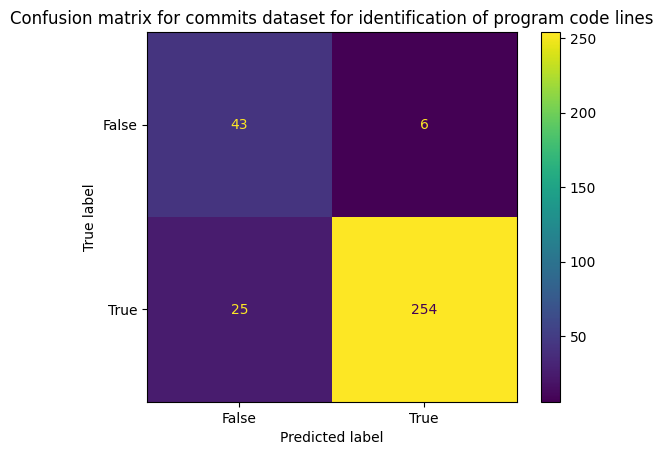

Accuracy score: 0.9054878048780488


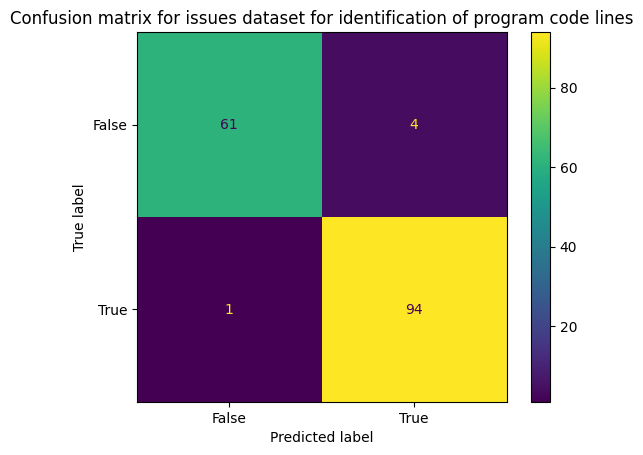

Accuracy score: 0.96875


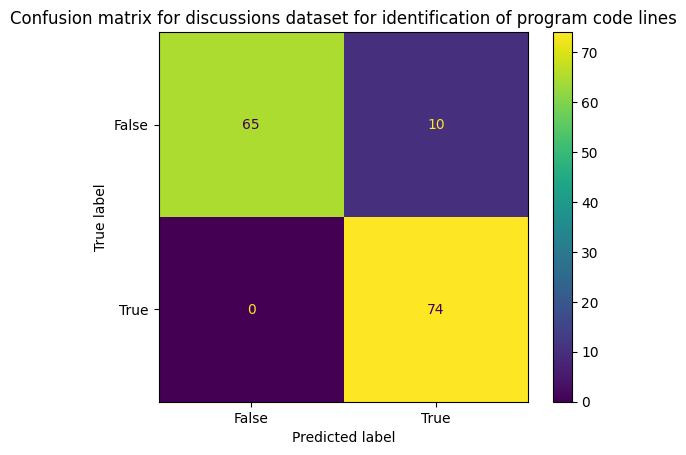

Accuracy score: 0.9328859060402684


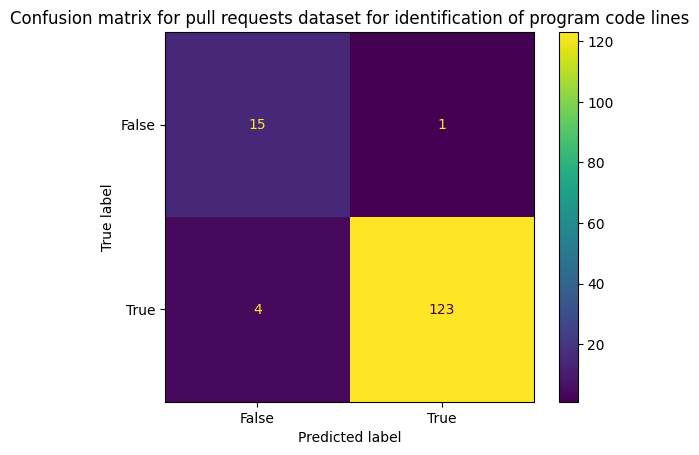

Accuracy score: 0.965034965034965


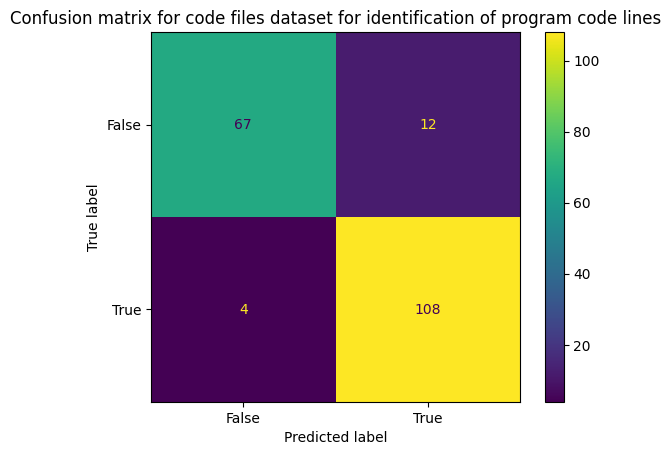

Accuracy score: 0.9162303664921466


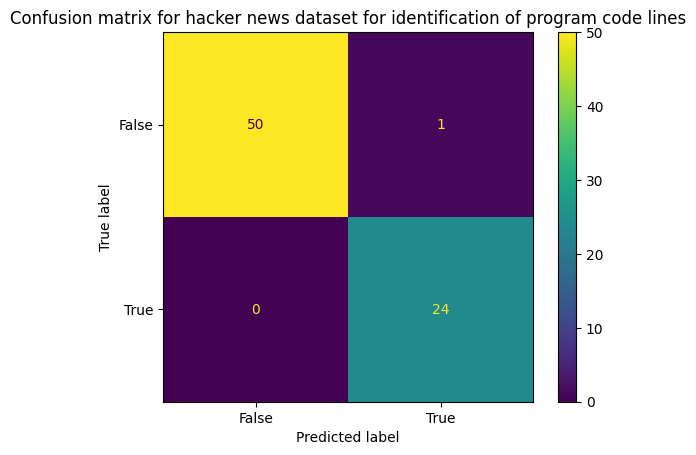

Accuracy score: 0.9866666666666667


In [23]:
with open(programming_language_detector_filename, 'r') as file:
    json_data = json.load(file)
    for elem in json_data:
        lines_data = json_data[elem]
        y_pred = [True if line_data['Language'] == ['prog', 'prog'] else False for line_data in lines_data]
        y_true = [line_data['is_program'] for line_data in lines_data]
        assert(len(y_pred) == len(y_true))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
        disp.plot()
        plt.title(f"Confusion matrix for {elem} dataset for identification of program code lines")
        plt.show()
        print(f"Accuracy score: {accuracy_score(y_true, y_pred)}")

In [24]:
with open(programming_language_detector_filename, 'r') as file:
    json_data = json.load(file)
    for elem in json_data:
        lines_data = json_data[elem]
        y_pred_correct = [True if any([line_data['Language'] == ['prog', 'prog'] and line_data['is_program'] == True, line_data['Language'] != ['prog', 'prog'] and line_data['is_program'] == False]) else False for line_data in lines_data]
        assert(len(lines_data) == len(y_pred_correct))
        for idx, pred in enumerate(y_pred_correct):
            if pred == False:
                line_data = lines_data[idx]
                if line_data['Language'] == ['prog', 'prog'] and line_data['is_program'] == False:
                    print(f"False-positive for line: '{line_data['Line']}', predicted program, but was not a program.")
                elif line_data['Language'] != ['prog', 'prog'] and line_data['is_program'] == True:
                    print(f"False-negative for line: '{line_data['Line']}', predicted not program, but was program.")
                else:
                    continue                

False-negative for line: '  â Test suite failed to run', predicted not program, but was program.
False-negative for line: '     â¢ If you are trying to use ECMAScript Modules, see https://jestjs.io/docs/ecmascript-modules for how to enable it.', predicted not program, but was program.
False-negative for line: '    Jest failed to parse a file. This happens e.g. when your code or its dependencies use non-standard JavaScript syntax, or when Jest is not configured to support such syntax.', predicted not program, but was program.
False-negative for line: '    SyntaxError: Cannot use import statement outside a module', predicted not program, but was program.
False-negative for line: '     â¢ If you need a custom transformation specify a "transform" option in your config.', predicted not program, but was program.
False-negative for line: '    ({"Object.<anonymous>":function(module,exports,require,__dirname,__filename,jest){import Game from './game.js';', predicted not program, but was pro

# Data exploration

In [20]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "hacker news"]

def count_conv_len_and_word_count(dataframe):
    dataframe_conversation_lengths, dataframe_conversation_lengths_for_avg, dataframe_prompt_lengths_sum, dataframe_prompt_wordcounts_sum = [], [], [], []
    for index, df_row in dataframe.iterrows():
        conversations = df_row.Conversations
        lengths = []
        conv_length = len(conversations)
        for conv_idx in range(len(conversations)):
            conversation = conversations[conv_idx]
            prompt = conversation["Prompt"]
            prompt_len = len(prompt)
            prompt_word_count = len(prompt.split())
            if len(dataframe_conversation_lengths_for_avg) <= conv_idx:
                dataframe_conversation_lengths_for_avg.append(1)
            else:
                dataframe_conversation_lengths_for_avg[conv_idx] += 1
            if len(dataframe_prompt_lengths_sum) <= conv_idx:
                dataframe_prompt_lengths_sum.append(prompt_len)
            else:
                dataframe_prompt_lengths_sum[conv_idx] += prompt_len
            if len(dataframe_prompt_wordcounts_sum) <= conv_idx:
                dataframe_prompt_wordcounts_sum.append(prompt_word_count)
            else:
                dataframe_prompt_wordcounts_sum[conv_idx] += prompt_word_count
        dataframe_conversation_lengths.append(conv_length)
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_lengths_sum))
    avg_prompt_lengths = [dataframe_prompt_lengths_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))]
    assert(len(dataframe_conversation_lengths_for_avg) == len(dataframe_prompt_wordcounts_sum))
    avg_prompt_word_counts = [dataframe_prompt_wordcounts_sum[indx] / dataframe_conversation_lengths_for_avg[indx] for indx in range(len(dataframe_conversation_lengths_for_avg))]
    conversation_count_per_conv_nr = np.zeros(max(dataframe_conversation_lengths))
    conv_len_dictionary = dict()
    for i in dataframe_conversation_lengths:
        conv_len_dictionary[i] = conv_len_dictionary.get(i, 0) + 1
        conversation_count_per_conv_nr[:i] += 1
    conv_len_dictionary = dict(sorted(conv_len_dictionary.items())) # Sort
    return conversation_count_per_conv_nr, conv_len_dictionary, avg_prompt_lengths, avg_prompt_word_counts
    
conversation_count_per_conv_nr_list, avg_prompt_lengths_list, avg_prompt_word_count_list = [], [], []
for idx in range(len(dataframes)):
    conversations_per_conv_nr, conv_dictionary, avg_prompt_lens, avg_prompt_wc = count_conv_len_and_word_count(dataframes[idx])
    conversation_count_per_conv_nr_list.append(conversations_per_conv_nr)
    avg_prompt_lengths_list.append(avg_prompt_lens)
    avg_prompt_word_count_list.append(avg_prompt_wc)
    print(f"Statistics for {dataframe_names[idx]} dataframe:")
    print("Dictionary containing the count of the lengths of the conversations: ", conv_dictionary)
    print("Average prompt lengths for each prompt: ", avg_prompt_lens)
    print("Average word count for each prompt: ", avg_prompt_wc)
    print("=============================================================================")

Statistics for commits dataframe:
Dictionary containing the count of the lengths of the conversations:  {1: 442, 2: 184, 3: 77, 4: 43, 5: 21, 6: 5, 7: 7, 8: 9, 9: 6, 10: 8, 11: 5, 12: 3, 13: 3, 14: 3, 15: 3, 16: 2, 17: 2, 18: 2, 19: 1, 20: 4, 22: 2, 23: 1, 24: 3, 25: 2, 26: 2, 27: 2, 28: 1, 30: 1, 31: 1, 33: 1, 34: 1, 47: 1, 64: 1, 70: 1}
Average prompt lengths for each prompt:  [2739.4670588235294, 422.0122549019608, 484.08035714285717, 367.8299319727891, 348.91346153846155, 396.34939759036143, 485.0897435897436, 412.11267605633805, 623.9516129032259, 732.2142857142857, 604.2916666666666, 465.0232558139535, 625.725, 424.9189189189189, 583.7647058823529, 220.09677419354838, 770.0, 197.8148148148148, 543.36, 542.625, 684.35, 231.4, 785.2777777777778, 150.58823529411765, 376.7857142857143, 145.91666666666666, 933.6, 148.75, 243.14285714285714, 156.71428571428572, 170.0, 448.0, 2029.0, 582.75, 370.3333333333333, 1249.0, 68.33333333333333, 520.3333333333334, 52.333333333333336, 108.3333333

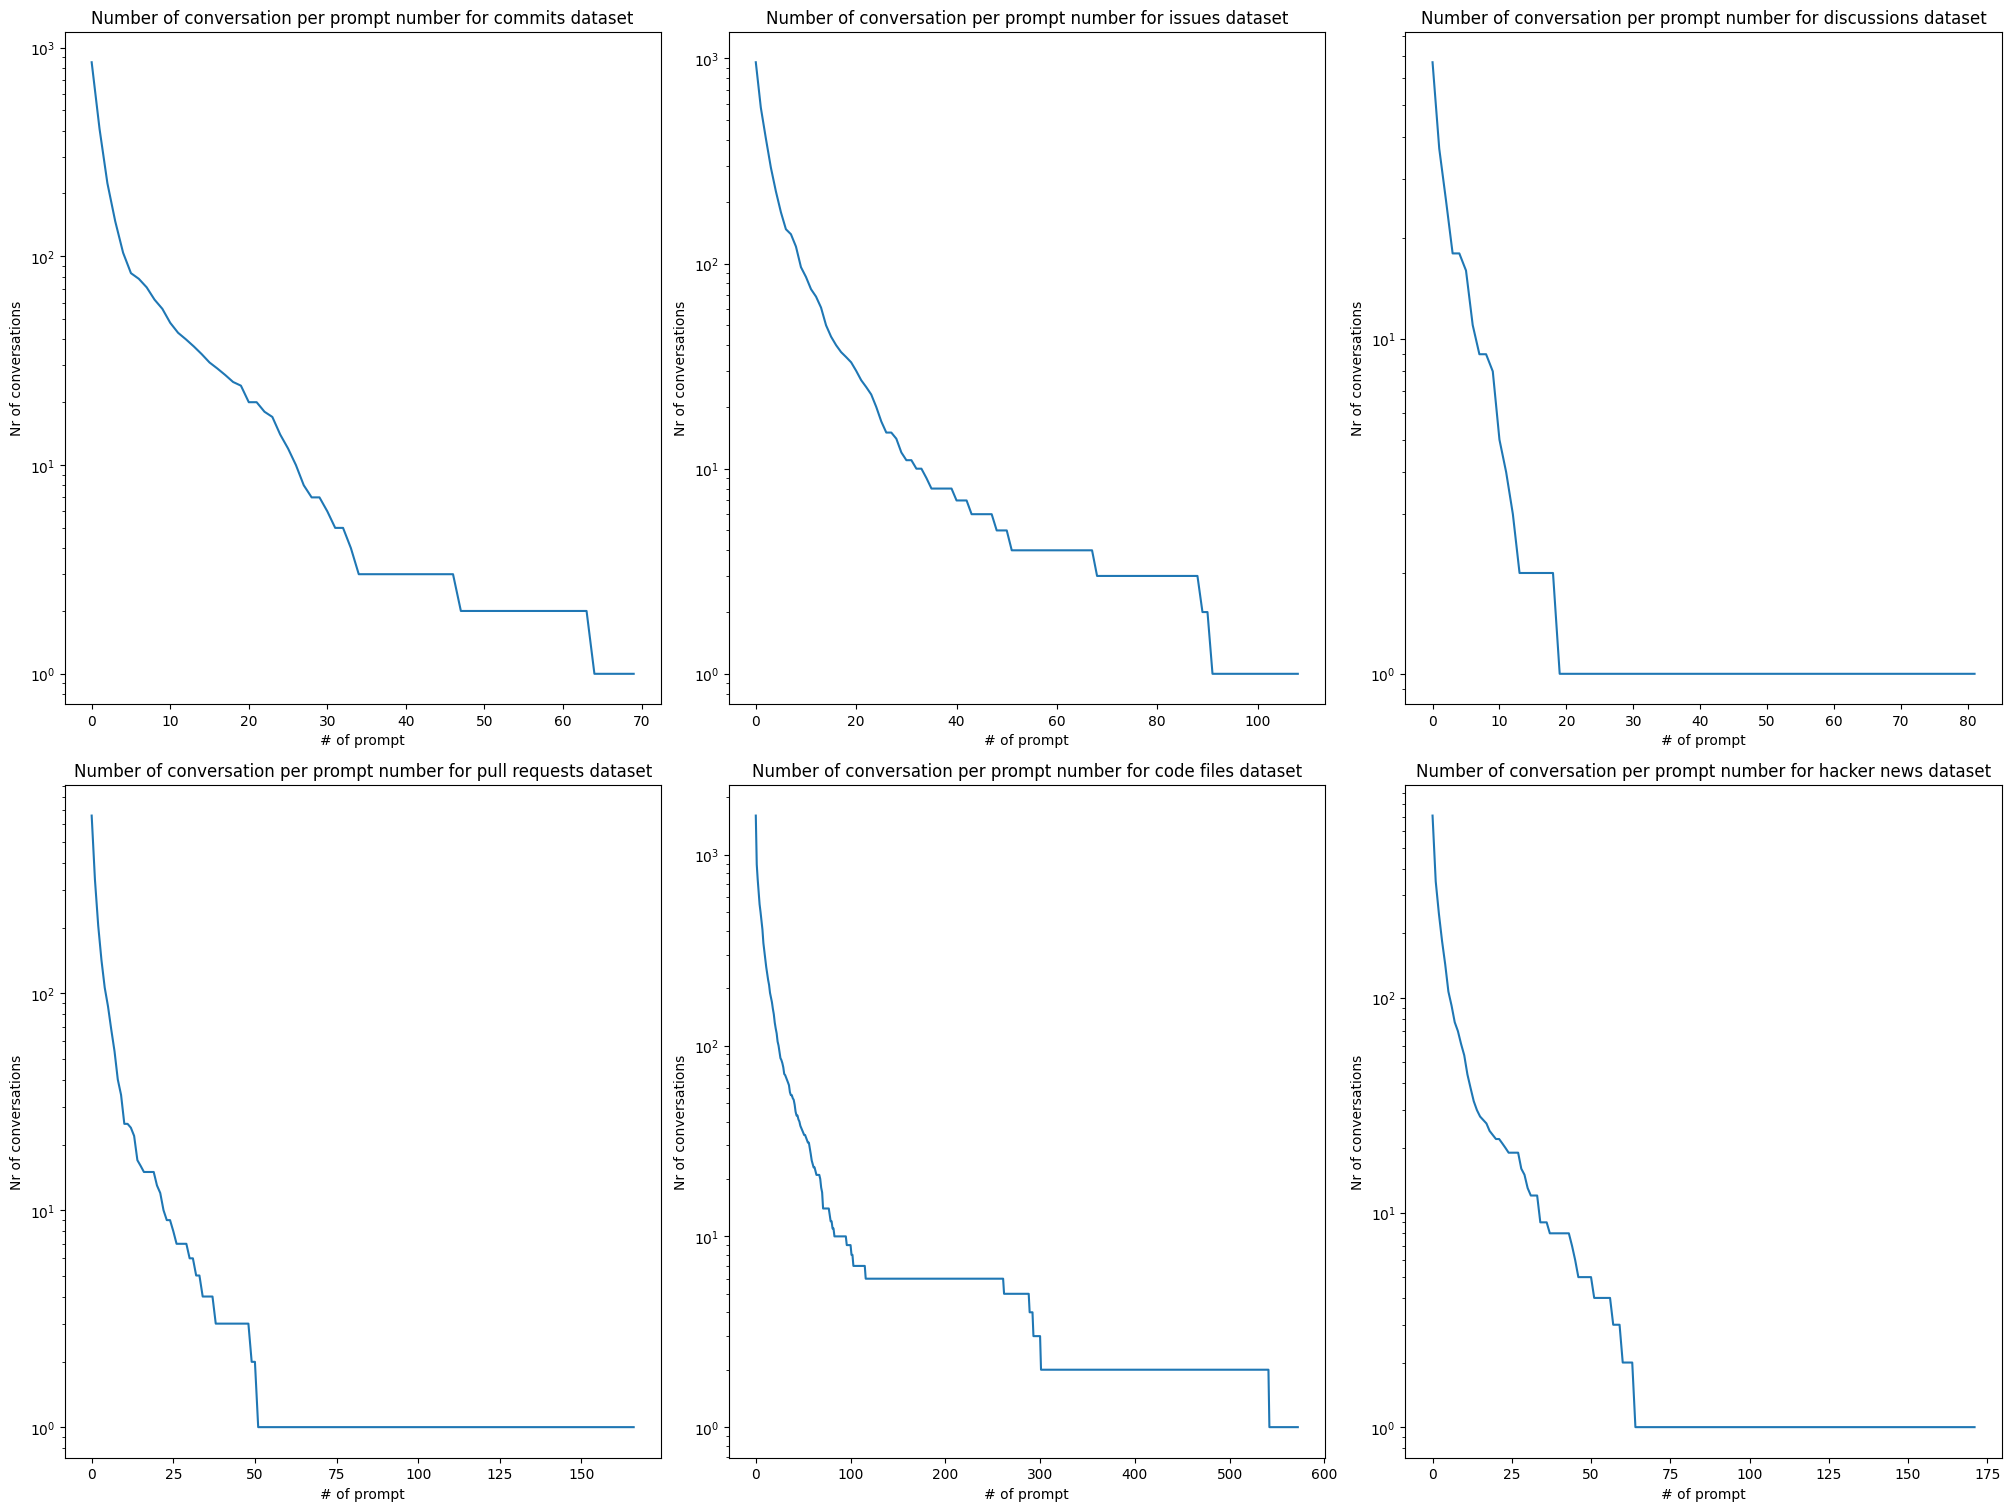

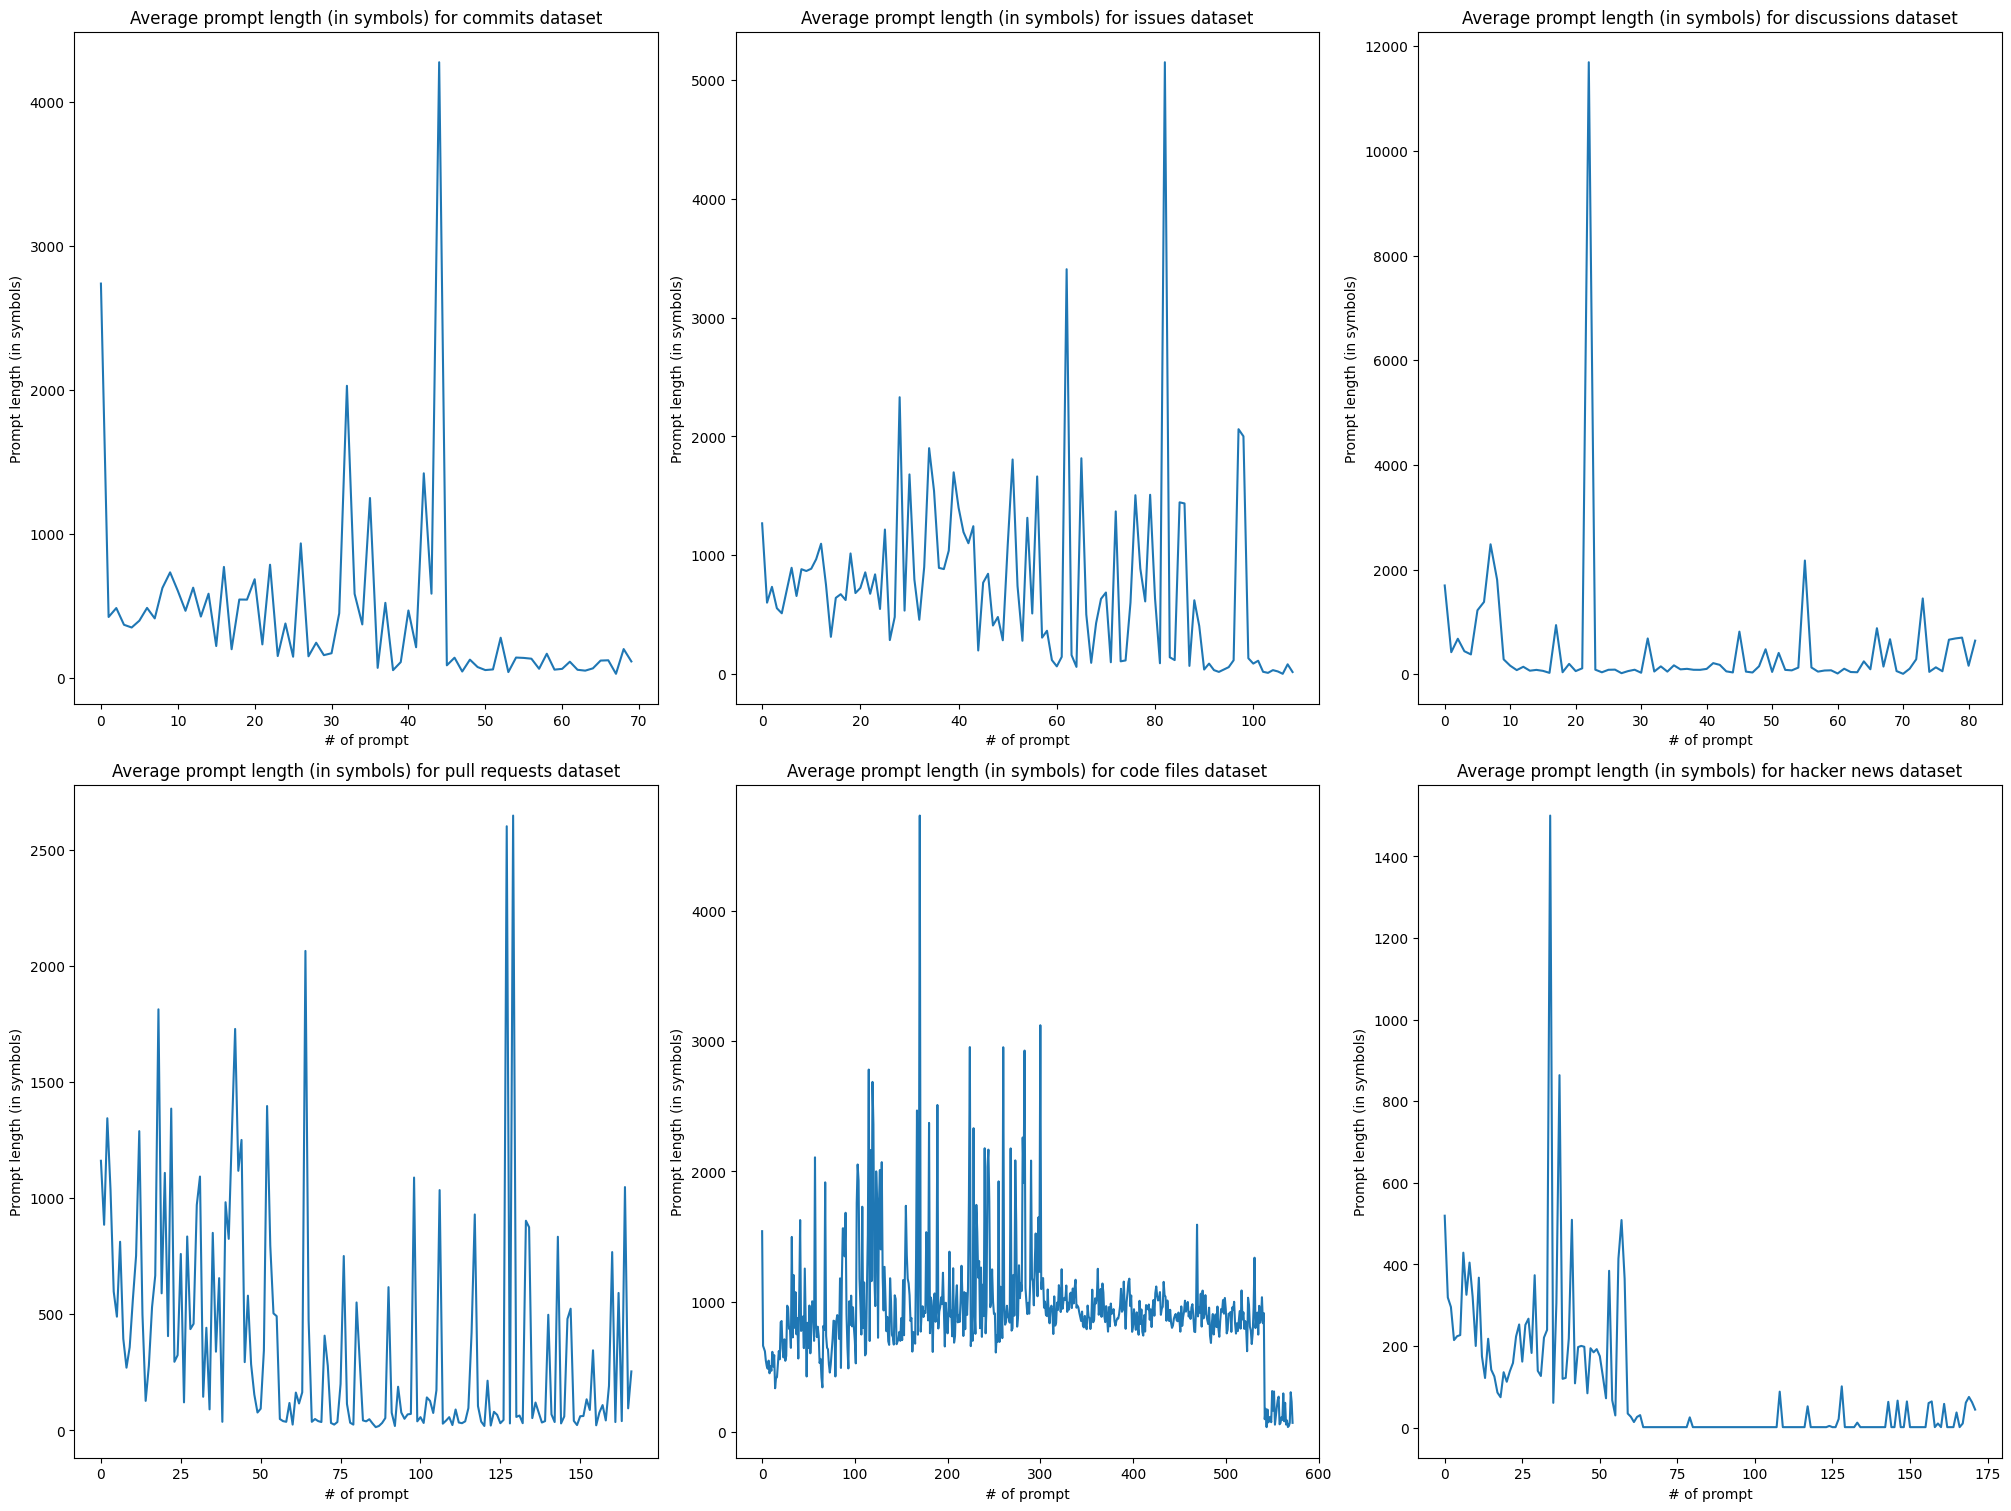

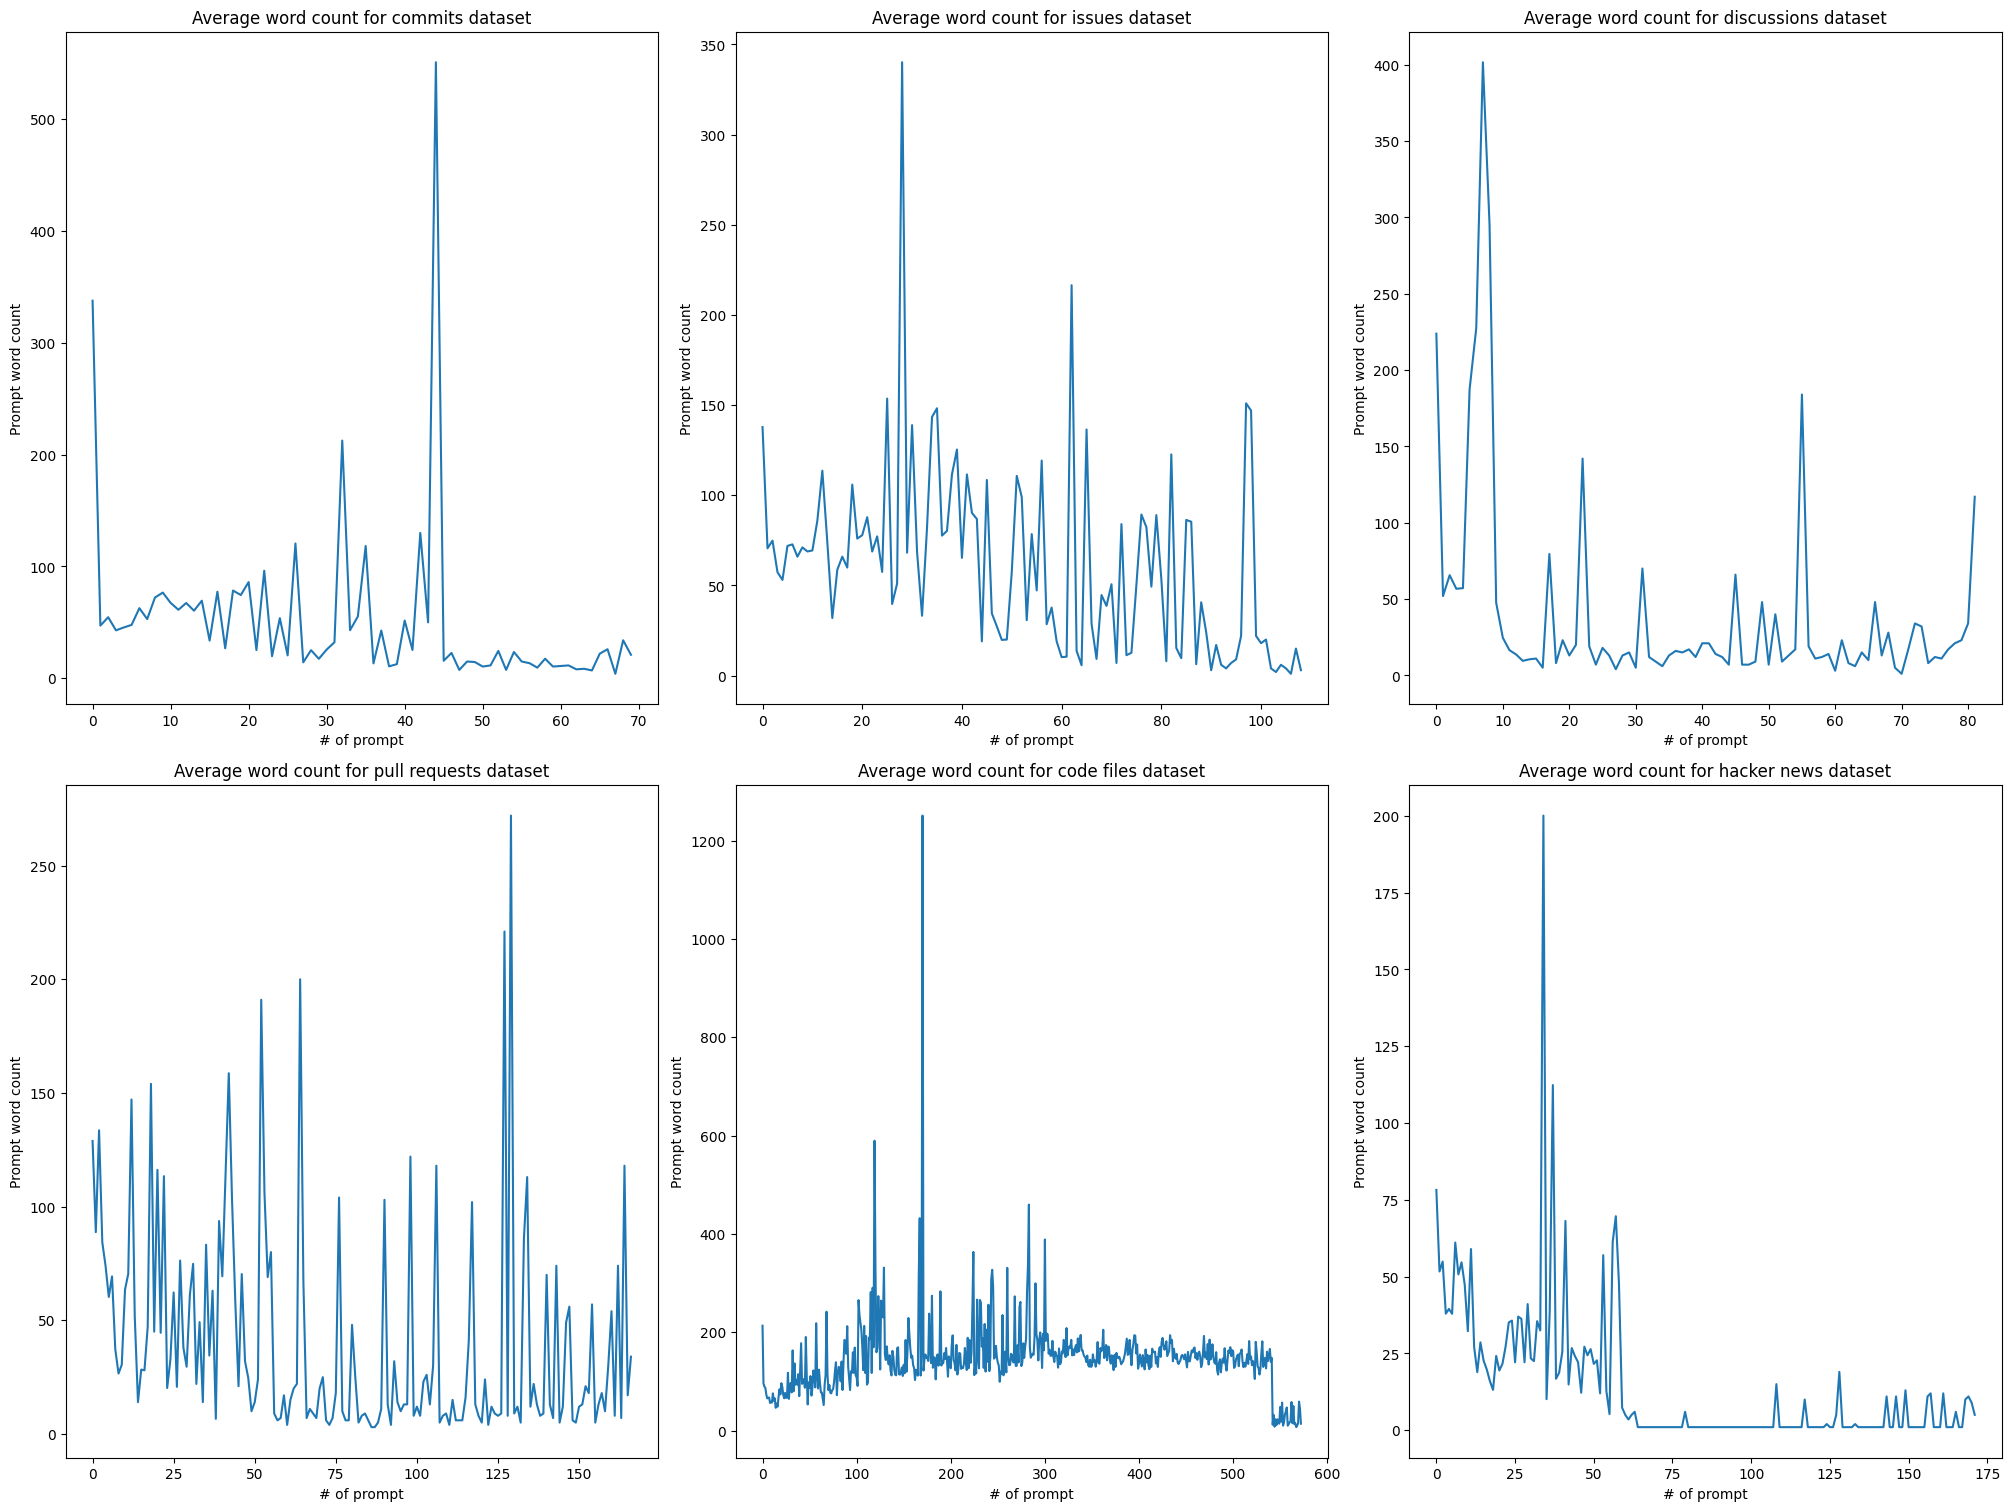

In [21]:
stats = [conversation_count_per_conv_nr_list, avg_prompt_lengths_list, avg_prompt_word_count_list]
stats_titles = ["Number of conversation per prompt number", "Average prompt length (in symbols)", "Average word count"]
stats_ylabels = ["Nr of conversations", "Prompt length (in symbols)", "Prompt word count"]

assert(len(stats) == len(stats_titles) == len(stats_ylabels))

for stat_idx, stat in enumerate(stats):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15), layout="constrained")
    plt.xlabel("Prompt number")
    plt.ylabel(f'{stats_ylabels[stat_idx]}')
    for idx in range(len(dataframes)):
        i,j = int(not(idx<3)),idx % 3
        if stat_idx == 0:
            axs[i,j].set_yscale("log")
        axs[i,j].set_title(f'{stats_titles[stat_idx]} for {dataframe_names[idx]} dataset')
        axs[i,j].set_xlabel(f'# of prompt')
        axs[i,j].set_ylabel(stats_ylabels[stat_idx])
        axs[i,j].plot(stat[idx])
        
    
    plt.show()

# Clean dataframes from the program code

In [22]:
dataframes_cleaned = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, hackernews_dataframe]

for idx, dataframe in enumerate(dataframes):
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        for conv in conversations:
            cleaned_lines = []
            lines_and_languages = detect_programming_languages(conv['Prompt'].split("\n"))
            for (line, language) in lines_and_languages:
                if language == "prog":
                    continue
                else:
                    cleaned_lines.append(line)
            conv['Prompt'] = "\n".join(cleaned_lines)

In [23]:
cleaned_dir_name = "cleaned_datasets"

if not os.path.exists(cleaned_dir_name):
    os.mkdir(cleaned_dir_name)

cleaned_dataframe_file_names = [f"{cleaned_dir_name}/cleaned_commits.json", f"{cleaned_dir_name}/cleaned_issues.json", f"{cleaned_dir_name}/cleaned_discussions.json", f"{cleaned_dir_name}/cleaned_pull_requests.json", f"{cleaned_dir_name}/cleaned_code_files.json", f"{cleaned_dir_name}/cleaned_hacker_news.json"]

for i, dataframe in enumerate(dataframes_cleaned):
    dataframe.reset_index(drop=True, inplace=True)
    jso = dataframe.to_json(orient='records')
    with open(cleaned_dataframe_file_names[i], 'w') as file:
        json.dump(json.loads(jso), file)